# Importación de librerias requeridas

In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [167]:
%pip install --quiet --upgrade pip
%pip install --quiet tensorboard


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip uninstall -y torch torchvision torchaudio
# Intenta primero la build CUDA 12.1:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
Found existing installation: torchaudio 2.5.1+cu121
Uninstalling torchaudio-2.5.1+cu121:
  Successfully uninstalled torchaudio-2.5.1+cu121
Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.5.1%2Bcu121-cp312-cp312-win_amd64.whl (2449.3 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp312-cp312-win_amd64.whl (6.1 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.5.1%2Bcu121-cp312-cp312-win_amd64.whl (4.1 MB)



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import torch
print("CUDA disponible:", torch.cuda.is_available())
print("Dispositivo:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


CUDA disponible: True
Dispositivo: NVIDIA GeForce GTX 1650


In [4]:
# -*- coding: utf-8 -*-
from __future__ import print_function, division

# ===========================
# CONFIGURACIÓN INICIAL
# ===========================

# tqdm es una librería para mostrar barras de progreso en ciclos (loops).
# "tqdm.auto" detecta si estamos en un notebook (como Kaggle o Jupyter)
# o en una terminal, y se adapta automáticamente sin mostrar advertencias.
from tqdm.auto import tqdm
tqdm.pandas()   # Integra tqdm con pandas → se ven barras de progreso en operaciones de pandas.

# ===========================
# MANEJO DE WEIGHTS & BIASES (wandb)
# ===========================
# wandb es una herramienta para registrar experimentos de machine learning.
# En Kaggle a veces genera errores o no queremos usarlo.
# Con esta configuración lo desactivamos por defecto y creamos un "plan B"
# para que el código siga funcionando aunque wandb falle o no esté instalado.

import os
os.environ.setdefault("WANDB_DISABLED", "true")  # Kaggle lo desactiva automáticamente

try:
    import wandb  # Intentamos importar wandb
except Exception as e:
    # Si falla la importación, creamos una clase de "simulación"
    # que actúa como reemplazo básico (stub).
    # Así, cuando en el código se llame a wandb.init() o wandb.log(),
    # no se producirá un error.
    class _WandbStub:
        def init(self, *args, **kwargs):
            class _Ctx:
                def __enter__(self): return self
                def __exit__(self, exc_type, exc, tb): pass
            return _Ctx()
        def log(self, *args, **kwargs): pass
        def watch(self, *args, **kwargs): pass
        def finish(self, *args, **kwargs): pass

    wandb = _WandbStub()  # Reemplazamos wandb por el "stub"

# ===========================
# IMPORTACIÓN DE LIBRERÍAS
# ===========================
# Estas librerías cubren diferentes tareas:
# - Numpy/Pandas: análisis de datos
# - PyTorch/Torchvision: redes neuronales
# - Albumentations: aumentación de imágenes
# - Scikit-learn: partición de datos
# - OpenCV/Skimage: procesamiento de imágenes
# - Matplotlib: visualización

import numpy as np
import pandas as pd
from numpy.typing import NDArray
from functools import reduce
from itertools import islice, chain
import math, copy

from PIL import Image

import torch
from torch import nn, Tensor
from torch.optim import Optimizer
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchsummary import summary  # Muestra la arquitectura de la red

# Albumentations: librería de aumentación de datos para imágenes
import albumentations as A

from sklearn.model_selection import train_test_split
from multiprocessing import cpu_count  # Para paralelizar procesos

import os.path as osp
from skimage import io, transform
import matplotlib.pyplot as plt
import typing as ty
import cv2

plt.ion()  # Activa el "modo interactivo" → las gráficas se actualizan automáticamente.

# ===========================
# EXPLORACIÓN DE DATOS EN KAGGLE
# ===========================
# Kaggle guarda los datasets en la carpeta "/kaggle/input".
# El siguiente bloque recorre esa carpeta y muestra los primeros 10 archivos encontrados.
# Esto ayuda a verificar qué datos tenemos disponibles sin abrir manualmente el explorador.
for root, dirs, filenames in os.walk('/kaggle/input'):
    for i, filepath in enumerate(filenames):
        if i >= 10:  # Solo mostramos hasta 10 archivos para no saturar la salida
            print()
            break
        print(osp.join(root, filepath))


In [198]:
# ===== AMP sin FutureWarning (compatible) =====
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

try:
    import torch.amp as _amp

    def amp_autocast():
        # PyTorch recientes prefieren: autocast('cuda', ...)
        try:
            return _amp.autocast('cuda', enabled=(device == 'cuda'))
        except TypeError:
            # Algunas versiones usan device_type=
            return _amp.autocast(device_type='cuda', enabled=(device == 'cuda'))

    # GradScaler con firma variable según versión
    try:
        SCALER = _amp.GradScaler('cuda', enabled=(device == 'cuda'))
    except TypeError:
        try:
            SCALER = _amp.GradScaler(device_type='cuda', enabled=(device == 'cuda'))
        except TypeError:
            SCALER = _amp.GradScaler(enabled=(device == 'cuda'))

except Exception:
    # Fallback: ruta vieja (puede mostrar warning en versiones nuevas)
    from torch.cuda.amp import autocast as _autocast, GradScaler as _GradScaler

    def amp_autocast():
        return _autocast(enabled=(device == 'cuda'))

    SCALER = _GradScaler(enabled=(device == 'cuda'))


# Ahora, vamos a crear la estructura del dataset

In [5]:
# ===========================
# Configuración básica en PyTorch
# ===========================

torch.manual_seed(32)  
# Fija la semilla para que los resultados sean reproducibles.

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Usando {device}')  
# Selecciona GPU si está disponible, de lo contrario usa CPU.

test = torch.ones((100, 100)).to(device)  
# Crea un tensor de prueba en el dispositivo seleccionado (CPU o GPU).

del test  
# Elimina el tensor de la memoria.

torch.cuda.empty_cache()  
# Limpia la memoria de la GPU, dejándola lista para entrenar modelos.


Usando cuda


In [6]:
import sys, os, torch
print("Python exe:", sys.executable)
print("Torch:", torch.__version__, "| CUDA build:", torch.version.cuda)
print("CUDA available?:", torch.cuda.is_available())
print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES"))
print("GPU count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU 0:", torch.cuda.get_device_name(0))


Python exe: d:\Salo\Maestria\2025_2\AD_II\RetoKaggle\env\Scripts\python.exe
Torch: 2.5.1+cu121 | CUDA build: 12.1
CUDA available?: True
CUDA_VISIBLE_DEVICES: None
GPU count: 1
GPU 0: NVIDIA GeForce GTX 1650


In [127]:
# ===========================
# CONFIGURACIÓN DE DIRECTORIOS Y PARÁMETROS
# ===========================

DATA_DIR = r"D:/Salo/Maestria/2025_2/AD_II/RetoKaggle/fa-ii-2025-ii-object-localization/"  # Carpeta donde Kaggle guarda el dataset (solo lectura)
WORK_DIR = r"D:/Salo/Maestria/2025_2/AD_II/RetoKaggle/outputs"                                  # Carpeta de trabajo (aquí se guardan outputs y resultados)
BATCH_SIZE = 8                                               # Tamaño de lote (batch) para el entrenamiento del modelo

# Ruta donde están guardadas las imágenes
img_dir = osp.join(DATA_DIR, "images")

# ===========================
# CARGA DEL DATASET
# ===========================

# Leemos el archivo CSV de entrenamiento que contiene:
# - nombre de la imagen
# - coordenadas de la caja delimitadora (bounding box: xmin, ymin, xmax, ymax)
# - clase del objeto
df = pd.read_csv(osp.join(DATA_DIR, "train.csv"))

# ===========================
# MAPEO DE CLASES A IDs
# ===========================

# Diccionario para convertir las clases (texto) en identificadores numéricos
# Diccionario que asigna un número a cada clase:
# - "no-mask" → 0
# - "mask"    → 1
obj2id  = {'no-mask':0,'mask':1}

# Diccionario inverso: convertir IDs numéricos en nombres de clases
id2obj  = {0:'no-mask',1:'mask'}

# Crear nueva columna "class_id" en el DataFrame con el valor numérico de la clase
df["class_id"] = df["class"].map(obj2id)

# ===========================
# SELECCIÓN DE COLUMNAS ÚTILES
# ===========================

# Definimos qué columnas necesitamos realmente del dataset
columns_f=['filename','xmin','ymin','xmax','ymax','class','class_id']

# Nos quedamos únicamente con esas columnas
df = df[columns_f].copy()


# Exploremos un poco los datos

In [129]:
df


filename  xmin  ymin  xmax  \
0    video_CDC-YOUTUBE_mp4-63_jpg.rf.2f4f64f6ef712f...   315   249   468   
1    IMG_4860_mp4-36_jpg.rf.01a053cabddff2cdd19f04e...   257   237   299   
2    IMG_1491_mp4-12_jpg.rf.9df64033aebef44b8bb9a6a...   291   245   582   
3    IMG_4861_mp4-64_jpg.rf.74ab6d1da8a1fa9b8fbb576...   231   229   577   
4    IMG_9950-1-_mp4-83_jpg.rf.74dca33810c23ba144d8...   107   168   515   
..                                                 ...   ...   ...   ...   
214  videoplayback-1-_mp4-58_jpg.rf.bfdf3258d74f87d...   408   168   465   
215  video_CDC-YOUTUBE_mp4-36_jpg.rf.5d17748e659665...   181   232   350   
216  IMG_4861_mp4-38_jpg.rf.880a11c3ebf59b3d0cf988f...   112   179   413   
217  How-to-Properly-Wear-a-Face-Mask-_-UC-San-Dieg...   268   134   382   
218  videoplayback-1-_mp4-28_jpg.rf.ffdc6b183c1a5f9...   396    85   479   

     ymax    class  class_id  
0     374  no-mask         0  
1     264  no-mask         0  
2     449     mask         1  
3     420  no-mask         0  
4     469  no-mask         0  
..    ...      ...       ...  
214   212  no-mask         0  
215   356     mask         1  
216   438  no-mask         0  
217   422  no-mask         0  
218   153  no-mask         0  

[219 rows x 7 columns]

In [130]:
# ===========================
# CARGA DE UNA IMAGEN DE EJEMPLO
# ===========================

# Construimos la ruta completa a un archivo de imagen específico.
# En este caso, "image_00077.jpeg" dentro de la carpeta del dataset.
img_filename = osp.join(DATA_DIR, "images", 'IMG_1493_mp4-21_jpg.rf.c5a3e237451e64e0674d5b0a6d556c25.jpg')

# 1) Lectura de la imagen con OpenCV (cv2)
# ----------------------------------------
# OpenCV lee las imágenes en formato BGR (Blue, Green, Red) por defecto.
img1 = cv2.imread(img_filename)

# Convertimos de BGR a RGB para que los colores sean correctos al visualizar con matplotlib.
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

# 2) Lectura de la misma imagen con skimage (io.imread)
# -----------------------------------------------------
# La función `io.imread` de scikit-image lee las imágenes directamente en formato RGB,
# por lo tanto no es necesario hacer la conversión de colores.
img2 = io.imread(img_filename)


In [131]:
# Mostramos la forma original de la imagen: (alto, ancho, canales) → (H, W, C)
print(img1.shape)

# Transponemos para pasar a formato (canales, alto, ancho) → (C, H, W),
# que es el requerido por PyTorch. -> como se vió en clase, pytorch trabaja
# con Channel first, no Channel last.
print(img1.transpose((2,0,1)).shape)


(640, 640, 3)
(3, 640, 640)


In [132]:
# ===========================
# ANÁLISIS EXPLORATORIO DE IMÁGENES
# ===========================

# Obtenemos la lista de nombres de archivos de las imágenes desde el DataFrame
list_image = list(df.filename)

# Inicializamos listas vacías donde guardaremos información de cada imagen
data_shape = []   # Guardará la forma completa de la imagen (alto, ancho, canales)
data_dim = []     # Guardará el número de dimensiones (ej: 2 para escala de grises, 3 para RGB)
data_w = []       # Guardará el ancho de la imagen
data_h = []       # Guardará la altura de la imagen

# Recorremos todas las imágenes con una barra de progreso (tqdm)
for i in tqdm(list_image):  # Puede tardar unos ~40 segundos en recorrer todo
    # Construimos la ruta completa de la imagen
    ruta_imagen = osp.join(img_dir, i)
    
    # Leemos la imagen con skimage → obtenemos forma y número de dimensiones
    imagen = io.imread(ruta_imagen)
    shapes = imagen.shape      # Ejemplo: (300, 400, 3)
    dimen = imagen.ndim        # Ejemplo: 3 si es RGB, 2 si es escala de grises
    
    # Leemos la imagen con PIL → obtenemos ancho y alto
    imagen = Image.open(ruta_imagen)
    w, h = imagen.size         # size devuelve (ancho, alto)
    
    # Guardamos toda la información en las listas
    data_w.append(w)
    data_h.append(h)
    data_shape.append(shapes)
    data_dim.append(dimen)

# Construimos un DataFrame con toda la información recopilada
data_w_h = pd.DataFrame(
    [list_image, data_shape, data_dim, data_w, data_h]
).T.rename(columns={0:'filename', 1:'shapes', 2:'ndim', 3:'w', 4:'h'})


  0%|          | 0/219 [00:00<?, ?it/s]

In [133]:
# Contamos cuántas imágenes tienen cada ancho (w).
# Sirve para verificar si todas las imágenes tienen el mismo tamaño
# o si hay variación en el dataset. -> tambien puedes hacerlo con 'h'
data_w_h['w'].value_counts()
# Esto quiere decir que existen 219 imagenes con 'w' -> 640

w
640    219
Name: count, dtype: int64

In [13]:
# Contamos cuántas imágenes tienen cada número de dimensiones (ndim).
# ndim = 3 → imágenes a color (RGB)
data_w_h['ndim'].value_counts()
# Se evidencian 219 imagenes con 3 canales (RGB)

ndim
3    219
Name: count, dtype: int64

In [14]:
# Contamos cuántas veces aparece cada forma (alto, ancho, canales) en el dataset.
# Ejemplo de salida:
# (300, 400, 3) → 120 imágenes con 300x400 píxeles y 3 canales (RGB)
# (224, 224, 3) → 80 imágenes con 224x224 píxeles y 3 canales (RGB)
data_w_h['shapes'].value_counts()
# Importante: Si hay múltiples tamaños, será necesario aplicar un redimensionamiento 'RESIZE' antes de entrenar la red neuronal.

shapes
(640, 640, 3)    219
Name: count, dtype: int64

In [15]:
# Contamos cuántas veces aparece cada clase en el dataset (según su ID numérico).
# Esto permite ver si el dataset está balanceado o si hay clases con muchas más imágenes que otras.
df['class_id'].value_counts()
# Recordemos: si se evidencia desvalance en clases, podemos hacer aumentación de datos -> librería de albumentation

class_id
0    135
1     84
Name: count, dtype: int64

In [16]:
# Contamos cuántas veces aparece cada clase en el dataset (en formato de texto).
# Esto muestra la distribución de imágenes entre las clases "mask" y "no-mask".
df['class'].value_counts()

class
no-mask    135
mask        84
Name: count, dtype: int64

In [17]:
# Verificamos si existen errores en las coordenadas de las cajas delimitadoras (bounding boxes).

# Caso 1: xmin >= xmax
# Esto indicaría que el lado izquierdo de la caja está a la derecha del lado derecho → caja inválida.

# Caso 2: ymin >= ymax
# Esto indicaría que la parte superior de la caja está por debajo de la parte inferior → caja inválida.
df[df['xmin']>=df['xmax']].shape, df[df['ymin']>=df['ymax']].shape

((0, 7), (0, 7))

In [134]:
# ===========================
# DIMENSIONES DE REFERENCIA (SOLO SI FUERA NECESARIO, PILAS CON ESTO)
# ===========================

# Ejemplo de dimensiones "reales" esperadas de un dataset

h_real = 720    # altura original de referencia (ejemplo)
w_real = 1280   # ancho original de referencia (ejemplo)

# Ejemplo de dimensiones de una imagen cargada

#h = alto, w = ancho, c = número de canales
h, w, c = 255, 400, 3

# NOTA IMPORTANTE PARA CHICOS:
# ---------------------------------
# Este bloque se deja como referencia para mostrar cómo comparar
# la resolución real de las imágenes frente a la resolución cargada.
# 
#En nuestro caso, todas las imágenes ya están EN LA MISMA DIMENSIÓN a 640x640 (LO VERIFICAMOS ANTES),
# lo cual es ideal para entrenar redes neuronales (no es necesario
# hacer redimensionamiento adicional).
#
# Solo se usaría este tipo de chequeo si el dataset tuviera imágenes
# con tamaños diferentes, para decidir si es necesario aplicar un "resize".

# Mi modelo

In [180]:
# ========== BLOQUES DE CONVOLUCIONES LIGERAS ==========

class ConvBNReLU(nn.Module):
    def __init__(self, in_c, out_c, k=3, s=1, p=None):
        super().__init__()
        if p is None:
            p = k // 2
        self.conv = nn.Conv2d(in_c, out_c, k, s, p, bias=False)
        self.bn   = nn.BatchNorm2d(out_c)
        self.act  = nn.ReLU(inplace=True)
    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class DWSeparableConv(nn.Module):
    """Depthwise 3x3 + Pointwise 1x1 (barato en FLOPs)"""
    def __init__(self, in_c, out_c, s=1):
        super().__init__()
        self.dw  = nn.Conv2d(in_c, in_c, 3, s, 1, groups=in_c, bias=False)
        self.pw  = nn.Conv2d(in_c, out_c, 1, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(in_c)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.act = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.act(self.bn1(self.dw(x)))
        x = self.act(self.bn2(self.pw(x)))
        return x

class DSResidualBlock(nn.Module):
    """Bloque residual con separables (simple y estable con VRAM baja)."""
    def __init__(self, c, s=1, expansion=1):
        super().__init__()
        mid = int(c * expansion)
        self.use_res = (s == 1)
        self.conv1 = nn.Conv2d(c, mid, 1, 1, 0, bias=False) if expansion != 1 else nn.Identity()
        self.bn1   = nn.BatchNorm2d(mid) if expansion != 1 else nn.Identity()
        self.dw    = nn.Conv2d(mid if expansion != 1 else c,
                               mid if expansion != 1 else c,
                               3, s, 1, groups=(mid if expansion != 1 else c), bias=False)
        self.bn2   = nn.BatchNorm2d(mid if expansion != 1 else c)
        self.pw    = nn.Conv2d(mid if expansion != 1 else c, c, 1, 1, 0, bias=False)
        self.bn3   = nn.BatchNorm2d(c)
        self.act   = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        out = x
        if not isinstance(self.conv1, nn.Identity):
            out = self.act(self.bn1(self.conv1(out)))
        out = self.act(self.bn2(self.dw(out)))
        out = self.bn3(self.pw(out))
        if self.use_res:
            out = out + identity
        return self.act(out)

# ========== BACKBONE LIGERO ==========
class CustomBackboneTiny(nn.Module):
    """
    CNN tipo MobileNet-like → salida [B, C_out] con GAP 1x1.
    """
    def __init__(self, in_channels=3, base_c=24, width_mult=1.0, dropout=0.2):
        super().__init__()
        c1 = int(base_c * 1 * width_mult)   # 24
        c2 = int(base_c * 2 * width_mult)   # 48
        c3 = int(base_c * 4 * width_mult)   # 96
        c4 = int(base_c * 6 * width_mult)   # 144
        c5 = int(base_c * 8 * width_mult)   # 192  -> C_out

        self.stem = ConvBNReLU(in_channels, c1, k=3, s=2)    # 640->320 (si entrenas a 640)
        self.stage2 = nn.Sequential(
            DWSeparableConv(c1, c1, s=1),
            DWSeparableConv(c1, c2, s=2),                    # 320->160
            DSResidualBlock(c2, s=1),
        )
        self.stage3 = nn.Sequential(
            DWSeparableConv(c2, c3, s=2),                    # 160->80
            DSResidualBlock(c3, s=1),
            DSResidualBlock(c3, s=1),
        )
        self.stage4 = nn.Sequential(
            DWSeparableConv(c3, c4, s=2),                    # 80->40
            DSResidualBlock(c4, s=1),
            DSResidualBlock(c4, s=1),
        )
        self.stage5 = nn.Sequential(
            DWSeparableConv(c4, c5, s=2),                    # 40->20
            DSResidualBlock(c5, s=1),
            DSResidualBlock(c5, s=1),
        )
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.drop = nn.Dropout(p=dropout)
        self.flatten = nn.Flatten(1)

        # init Kaiming
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight); nn.init.zeros_(m.bias)

        self.out_channels = c5

    def forward(self, x):
        x = self.stem(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.gap(x)
        x = self.drop(x)
        x = self.flatten(x)     # [B, C_out]
        return x

# ===== Aquí conectas el backbone reemplazando al que tenías (p.ej., VGG16) =====
pretrained_model = CustomBackboneTiny(
    in_channels=3,
    base_c=24,           # si te sobra VRAM, sube a 32
    width_mult=1.0,
    dropout=0.2
).to(device)
pretrained_model.eval()  # para inspección de forma (en entrenamiento usa .train())


CustomBackboneTiny(
  (stem): ConvBNReLU(
    (conv): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU(inplace=True)
  )
  (stage2): Sequential(
    (0): DWSeparableConv(
      (dw): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=24, bias=False)
      (pw): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
    )
    (1): DWSeparableConv(
      (dw): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
      (pw): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

# Normalizamos los bounding box

In [135]:
# Mostramos estadísticas básicas (min, max, promedio, etc.)
# de las coordenadas de las bounding boxes: ymin, ymax, xmin, xmax.
# Sirve para verificar que las cajas estén dentro de los rangos esperados
# y detectar valores anómalos en las anotaciones.
print(df[["ymin", "ymax", "xmin", "xmax"]].describe())

             ymin        ymax        xmin        xmax
count  219.000000  219.000000  219.000000  219.000000
mean   175.296804  371.278539  217.068493  446.849315
std     67.509690   97.632620  108.656136  104.015128
min      3.000000  145.000000    0.000000  146.000000
25%    134.000000  333.000000  154.000000  382.500000
50%    168.000000  394.000000  204.000000  466.000000
75%    224.000000  431.500000  274.500000  513.000000
max    420.000000  640.000000  557.000000  640.000000


In [ ]:
"""

import os

# ===========================
# CONVERSIÓN AL FORMATO YOLO
# ===========================

# Calculamos centro (cx, cy) y ancho/alto (bw, bh) de las cajas
df["cx"] = (df["xmin"] + df["xmax"]) / 2
df["cy"] = (df["ymin"] + df["ymax"]) / 2
df["bw"] = df["xmax"] - df["xmin"]
df["bh"] = df["ymax"] - df["ymin"]

# Nos quedamos con columnas útiles
yolo_df = df[["filename", "class_id", "cx", "cy", "bw", "bh"]]

# Carpeta donde guardar los labels (ajusta a tu estructura)
labels_dir = "labels"
os.makedirs(labels_dir, exist_ok=True)

# Guardamos un .txt por cada imagen
for fname, group in yolo_df.groupby("filename"):
    label_path = os.path.join(labels_dir, fname.replace(".jpg", ".txt"))
    with open(label_path, "w") as f:
        for _, row in group.iterrows():
            f.write(f"{row.class_id} {row.cx:.6f} {row.cy:.6f} {row.bw:.6f} {row.bh:.6f}\n")
            """


In [136]:
# ===========================
# NORMALIZACIÓN DE COORDENADAS DE LAS BOUNDING BOXES
# ===========================

# Altura y ancho reales de las imágenes
h_real = 640
w_real = 640

# Normalizamos dividiendo entre las dimensiones reales
df["xmin"] = df["xmin"] / w_real
df["xmax"] = df["xmax"] / w_real
df["ymin"] = df["ymin"] / h_real
df["ymax"] = df["ymax"] / h_real

# ===========================
# VERIFICACIÓN
# ===========================
print("Rangos de coordenadas normalizadas:")
for col in ["xmin", "xmax", "ymin", "ymax"]:
    print(f"{col}: min={df[col].min():.4f}, max={df[col].max():.4f}")

# Verificamos que todas estén en [0,1]
valid = ((df[["xmin","ymin"]] >= 0).all().all() and 
         (df[["xmax","ymax"]] <= 1).all().all())
print("\n¿Todas las cajas están dentro de [0,1]?:", valid)


Rangos de coordenadas normalizadas:
xmin: min=0.0000, max=0.8703
xmax: min=0.2281, max=1.0000
ymin: min=0.0047, max=0.6562
ymax: min=0.2266, max=1.0000

¿Todas las cajas están dentro de [0,1]?: True


In [137]:
# Ahora visualizamos el df con los bbox normalizados
df

filename      xmin      ymin  \
0    video_CDC-YOUTUBE_mp4-63_jpg.rf.2f4f64f6ef712f...  0.492188  0.389062   
1    IMG_4860_mp4-36_jpg.rf.01a053cabddff2cdd19f04e...  0.401562  0.370312   
2    IMG_1491_mp4-12_jpg.rf.9df64033aebef44b8bb9a6a...  0.454688  0.382812   
3    IMG_4861_mp4-64_jpg.rf.74ab6d1da8a1fa9b8fbb576...  0.360938  0.357812   
4    IMG_9950-1-_mp4-83_jpg.rf.74dca33810c23ba144d8...  0.167187  0.262500   
..                                                 ...       ...       ...   
214  videoplayback-1-_mp4-58_jpg.rf.bfdf3258d74f87d...  0.637500  0.262500   
215  video_CDC-YOUTUBE_mp4-36_jpg.rf.5d17748e659665...  0.282813  0.362500   
216  IMG_4861_mp4-38_jpg.rf.880a11c3ebf59b3d0cf988f...  0.175000  0.279687   
217  How-to-Properly-Wear-a-Face-Mask-_-UC-San-Dieg...  0.418750  0.209375   
218  videoplayback-1-_mp4-28_jpg.rf.ffdc6b183c1a5f9...  0.618750  0.132812   

         xmax      ymax    class  class_id  
0    0.731250  0.584375  no-mask         0  
1    0.467187  0.412500  no-mask         0  
2    0.909375  0.701562     mask         1  
3    0.901563  0.656250  no-mask         0  
4    0.804688  0.732812  no-mask         0  
..        ...       ...      ...       ...  
214  0.726562  0.331250  no-mask         0  
215  0.546875  0.556250     mask         1  
216  0.645312  0.684375  no-mask         0  
217  0.596875  0.659375  no-mask         0  
218  0.748437  0.239063  no-mask         0  

[219 rows x 7 columns]

In [138]:
# ===========================
# PARTICIÓN ENTRENAMIENTO / VALIDACIÓN (estratificada)
# ===========================
# Dividimos el DataFrame 'df' en dos subconjuntos:
#  - train_df: datos para entrenar el modelo (75%)
#  - val_df:   datos para validar el modelo (25%)
#
# Parámetros clave:
#  - stratify=df['class_id']  → mantiene la misma proporción de clases en
#    train y val (muy importante si el dataset está desbalanceado).
#  - test_size=0.25           → 25% de los datos va a validación.
#  - random_state=42           → semilla para reproducibilidad del split.
#
# Requisitos:
#  - La columna 'class_id' debe existir, que de hecho, está!
#  - Cada clase debe tener muestras suficientes para poder estratificar
#    (si alguna clase tiene muy pocos ejemplos, puede dar ValueError)
train_df, val_df = train_test_split(
    df, stratify=df['class_id'], test_size=0.25, random_state=42
)

# Tamaños resultantes de cada partición
print(train_df.shape)
print(val_df.shape)

(164, 7)
(55, 7)


**Importante**: El set de entrenamiento debe tener información acerca de la clase y las coordenadas correspondientes a los bbox

In [28]:
# ===========================
# DISTRIBUCIÓN DE CLASES EN TRAIN (en %)
# ===========================
# ahora verificamos que la distribución de las clases se mantengan en el train
# Útil para verificar que el split estratificado mantuvo el balance de clases.
train_df['class'].value_counts(normalize=True) * 100

class
no-mask    61.585366
mask       38.414634
Name: proportion, dtype: float64

In [139]:
# ===========================
# DISTRIBUCIÓN DE CLASES EN TEST (en %)
# ===========================
# ahora verificamos que la distribución de las clases se mantengan en el test
# Útil para verificar que el split estratificado mantuvo el balance de clases.
val_df['class_id'].value_counts(1) * 100

class_id
0    61.818182
1    38.181818
Name: proportion, dtype: float64

Hay que tener presente que el conjunto de prueba solo contiene el nombre de archivo de cada imagen (se puede verificar en la data), por lo que tenemos que generar predicciones y enviarlas a la competencia de Kaggle.

In [140]:
def _compose_transforms(transforms):
    if transforms is None:
        return None
    if callable(transforms):
        return transforms
    if isinstance(transforms, (list, tuple)):
        def _run(sample):
            for t in transforms:
                sample = t(sample)
            return sample
        return _run
    raise TypeError("transform debe ser None, callable, o lista/tupla de callables.")

class maskDataset(Dataset):
    """
    Dataset de localización. Devuelve un dict con:
      - 'image': np.ndarray (H, W, 3) float32 en [0,1]
      - 'bbox' : np.ndarray (N, 4) float32 en [0,1] en formato (xmin, ymin, xmax, ymax) si labeled=True
      - 'class_id': np.ndarray (N,) int64 si labeled=True

    Args:
        df: DataFrame con columnas al menos: ['filename','xmin','ymin','xmax','ymax'] y si labeled, 'class_id'.
            Puede tener múltiples filas por filename (una por objeto) si expect_multi=True.
        root_dir: carpeta donde viven las imágenes.
        labeled: si False, solo devuelve 'image'.
        transform: callable o lista de callables que reciben y devuelven el dict sample.
        output_size: tuple (W, H) para redimensionar con cv2.resize. Las bboxes se asumen ya normalizadas [0,1].
        expect_multi: si True, agrupa múltiples cajas por imagen usando df.groupby('filename').
    """

    def __init__(
        self,
        df,
        root_dir,
        labeled=True,
        transform=None,
        output_size=None,      # (W, H)
        expect_multi=False,
    ):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.labeled = labeled
        self.output_size = output_size
        self.transform = _compose_transforms(transform)
        self.expect_multi = expect_multi

        # Validaciones suaves
        req_cols = {'filename', 'xmin', 'ymin', 'xmax', 'ymax'}
        missing = req_cols - set(self.df.columns)
        if missing:
            raise ValueError(f"Faltan columnas en df: {missing}")
        if self.labeled and 'class_id' not in self.df.columns:
            raise ValueError("Falta columna 'class_id' cuando labeled=True.")

        if expect_multi:
            # índice por filename -> array de índices de filas
            self.files = self.df['filename'].unique().tolist()
            self.index_map = self.df.groupby('filename').indices
        else:
            # una fila por imagen
            self.files = self.df['filename'].tolist()

    def __len__(self):
        return len(self.files)

    def _load_image_rgb(self, path):
        img = io.imread(path)  # skimage suele devolver RGB
        if img is None:
            raise FileNotFoundError(f"Image not found: {path}")

        # Asegurar 3 canales
        if img.ndim == 2:  # gris -> RGB
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.ndim == 3 and img.shape[2] == 4:  # RGBA -> RGB
            img = img[:, :, :3]

        # Redimensionar si procede (cv2 espera (W,H))
        if self.output_size is not None:
            img = cv2.resize(img, self.output_size)

        # A float32 [0,1]
        if img.dtype != np.float32:
            img = img.astype(np.float32)
        if img.max() > 1.0:
            img /= 255.0

        return img

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.item()

        fname = self.files[idx]
        img_path = osp.join(self.root_dir, fname)
        image = self._load_image_rgb(img_path)

        sample = {'image': image}

        if self.labeled:
            if self.expect_multi:
                rows = self.df.iloc[self.index_map[fname]]
                boxes = rows[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy(dtype=np.float32)
                labels = rows['class_id'].to_numpy(dtype=np.int64)
            else:
                row = self.df.iloc[idx]
                boxes = row[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy(dtype=np.float32)[None, :]  # (1,4)
                labels = np.array([row['class_id']], dtype=np.int64)                               # (1,)

            # Clip de seguridad a [0,1] por si hay ruido numérico
            if boxes.size:
                boxes = np.clip(boxes, 0.0, 1.0)

            sample.update({'bbox': boxes, 'class_id': labels})

        if self.transform is not None:
            sample = self.transform(sample)

        return sample

In [141]:
def draw_bbox(img, bbox, color,thickness: int = 3):
    # Dibuja un único cuadro delimitador (bounding box) sobre una imagen.
    # Parámetros:
    #   img      : np.ndarray (imagen en formato BGR si se usa OpenCV)
    #   bbox     : iterable con 4 enteros/píxeles en el orden (xmin, ymin, xmax, ymax)
    #              IMPORTANTE: estas coordenadas deben estar en píxeles, no normalizadas.
    #   color    : tupla BGR (por ejemplo, (255,0,0) para azul en OpenCV)
    #   thickness: grosor de la línea del rectángulo
    # Retorna:
    #   img con el rectángulo dibujado (la operación modifica la imagen in-place)
    xmin, ymin, xmax, ymax = bbox
    img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color, thickness)
    return img

def normalize_bbox(bbox, h: int, w: int):
    """Escala las coordenadas normalizadas al tamaño real de la imagen."""
    # Convierte una caja en formato normalizado [0,1] a píxeles enteros según (w, h).
    # Parámetros:
    #   bbox: iterable [xmin_norm, ymin_norm, xmax_norm, ymax_norm] en [0,1]
    #   h   : altura de la imagen en píxeles
    #   w   : ancho de la imagen en píxeles
    # Retorna:
    #   lista [xmin_px, ymin_px, xmax_px, ymax_px] como enteros
    return [
        int(bbox[0] * w),  # xmin
        int(bbox[1] * h),  # ymin
        int(bbox[2] * w),  # xmax
        int(bbox[3] * h),  # ymax
    ]

def draw_bboxes(imgs, bboxes, colors,thickness):
    """Dibuja múltiples cuadros delimitadores en imágenes, escalando según h y w."""
    # Dibuja una lista de bounding boxes sobre una lista de imágenes.
    # Parámetros:
    #   imgs    : lista de imágenes (np.ndarray) de igual longitud que bboxes y colors
    #   bboxes  : lista de cajas en píxeles [(xmin,ymin,xmax,ymax), ...]
    #             NOTA: esta función asume que las cajas YA están en píxeles.
    #   colors  : lista de colores BGR por cada imagen/caja (o reutilizadas externamente)
    #   thickness: grosor del rectángulo
    # Retorna:
    #   lista de imágenes con las cajas dibujadas
    for i, (img, bbox, color) in enumerate(zip(imgs, bboxes, colors)):
        imgs[i] = draw_bbox(img, bbox, color,thickness)
    return imgs

def draw_classes(imgs, classes, colors, origin, prefix: str ='',fontScale : int = 2):
    """Dibuja las clases en las imágenes."""
    # Escribe el nombre de la clase sobre cada imagen.
    # Parámetros:
    #   imgs     : lista de imágenes (np.ndarray)
    #   classes  : iterable de ids de clase (p. ej., [[1], [0], ...] o [1,0,...])
    #   colors   : lista de colores BGR para el texto
    #   origin   : punto (x, y) donde iniciar el texto en cada imagen
    #   prefix   : texto opcional para anteponer (por ejemplo, "pred: ")
    #   fontScale: tamaño de fuente en OpenCV
    # Dependencias externas esperadas:
    #   - Un diccionario global 'id2obj' para mapear id → nombre de clase.
    # Nota: la variable 'c' usada más abajo no está definida en este bloque.
    #       Se mantiene tal cual por requerimiento del enunciado.
    for i, (img, class_id, color) in enumerate(zip(imgs, classes, colors)):
        if type(c)==list:
            name_class_=id2obj[classes[i]]
        else:
            name_class_=id2obj[classes[i][0]]
        imgs[i] = cv2.putText(
            img, f'{prefix}{name_class_}', #class_id.squeeze()
            origin, cv2.FONT_HERSHEY_SIMPLEX,
            fontScale , color, 2, cv2.LINE_AA
        )
    return imgs

def draw_predictions(imgs, classes, bboxes, colors, origin,thickness,fontScale):
    """
    Combina las funciones anteriores para dibujar cuadros delimitadores
    y clases en las imágenes.
    """
    # Flujo:
    #   1) Verifica que todas las listas tengan longitud > 0.
    #   2) Si hay un solo color, lo replica para todas las imágenes.
    #   3) Dibuja las cajas.
    #   4) Dibuja las etiquetas de clase.
    # Parámetros:
    #   imgs, classes, bboxes: listas alineadas por índice
    #   colors               : lista de colores BGR (o uno solo para todos)
    #   origin               : punto (x,y) para el texto
    #   thickness            : grosor del rectángulo
    #   fontScale            : tamaño del texto
    # Retorna:
    #   lista de imágenes con predicciones (cajas + etiquetas) dibujadas
    assert all(len(x) > 0 for x in [imgs, classes, bboxes, colors])
    if len(colors) == 1:
        colors = [colors[0] for _ in imgs]
    imgs = draw_bboxes(imgs, bboxes, colors,thickness)
    imgs = draw_classes(imgs, classes, colors, origin,"",fontScale)
    return imgs


In [142]:
h, w, c = 256, 256, 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..150.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..150.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..150.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..150.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..150.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..150.0].


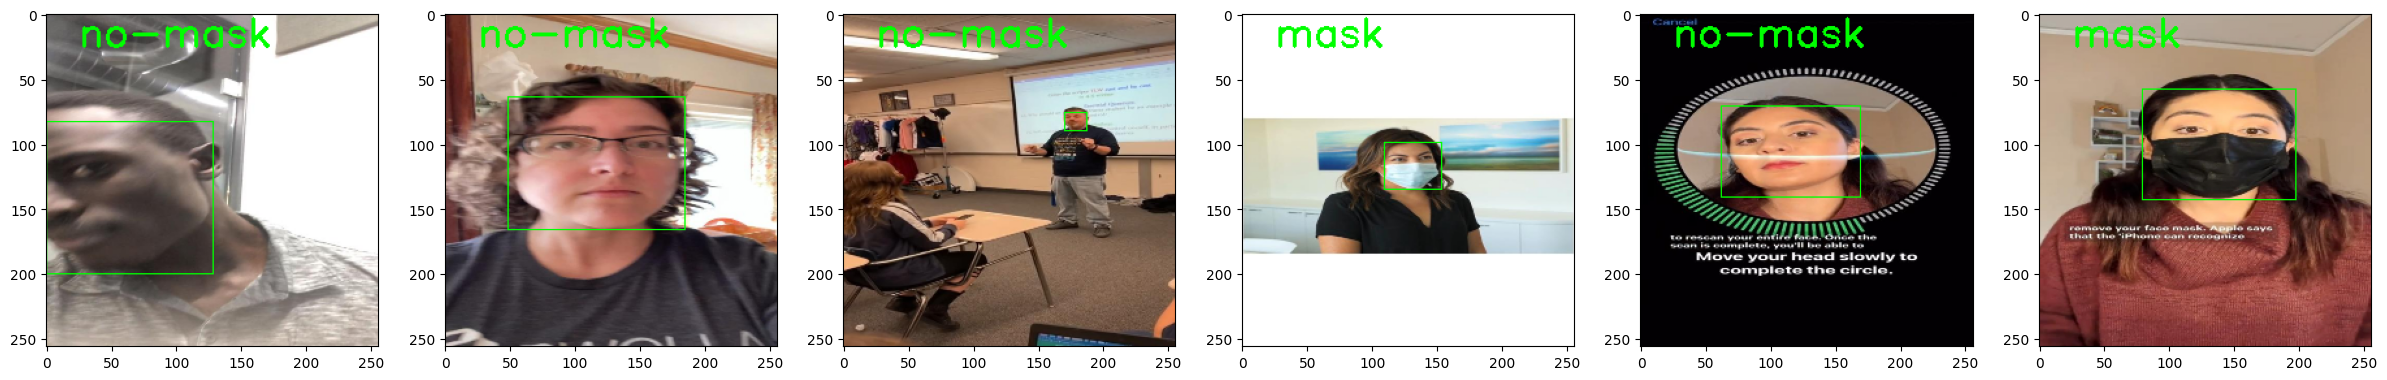

In [143]:
# ===========================
# VISUALIZACIÓN DE MUESTRAS CON CAJAS Y CLASES
# ===========================

# Carpeta raíz donde están las imágenes del split de entrenamiento
train_root_dir = osp.join(DATA_DIR, "images")#, "train"

# Instanciamos el Dataset con el DataFrame de train y forzamos tamaño de salida (w, h)
# Nota: 'w' y 'h' deben estar definidos previamente (por ejemplo, 640, 640).
train_ds = maskDataset(train_df, root_dir=train_root_dir,output_size=(w,h))

# Número de imágenes a mostrar y desde qué índice empezar
num_imgs = 6
start_idx = 0

# Tomamos 'num_imgs' muestras consecutivas a partir de 'start_idx'
samples = [train_ds[i] for i in range(start_idx, num_imgs)]

# Extraemos por separado las imágenes, bboxes y clases de cada sample
imgs = [s['image'] for s in samples]
# Convertimos las cajas normalizadas [0,1] a píxeles con (w,h) de salida
bboxes = [normalize_bbox(s['bbox'].squeeze(),h,w) for s in samples]
classes = [s['class_id'] for s in samples]

# Dibujamos predicciones: cajas + etiquetas
# - colors: lista con un color (BGR) que se reutiliza para todas las imágenes
# - origin: punto (x,y) para el texto (10% del ancho y alto)
# - thickness y fontScale: grosor de línea y tamaño de fuente
imgs = draw_predictions(imgs, classes, bboxes, [(0, 150, 0)], (int(w*0.1), int(h*0.1)),thickness = 1,fontScale=1)#(150, 10)

# Creamos una figura grande y colocamos cada imagen en una subgráfica
fig = plt.figure(figsize=(30, num_imgs))

for i, img in enumerate(imgs):
    fig.add_subplot(1, num_imgs, i+1)
    plt.imshow(img)

# Mostramos el collage de imágenes con sus cajas y clases
plt.show()

# Normalización de imagen

In [144]:
# ===========================
# CÁLCULO DE MEDIA Y DESVIACIÓN ESTÁNDAR (por canal) DEL DATASET
# ===========================
# Objetivo: estimar las estadísticas de color (mean y std de R, G, B) para
# usarlas luego en una normalización tipo torchvision.transforms.Normalize(mean, std).

# Dataset de entrenamiento (imágenes ya cargadas desde train_df). PILAS CON LA FUGA DE DATOS
# Por eso se hace la normalización con el set de train, recuerden que el test no lo puede ver el model
# Nota: output_size=(w, h) garantiza forma consistente (p. ej., 640x640).
train_ds = maskDataset(train_df, root_dir=train_root_dir,output_size=(w,h))#,output_size=(255,255)

# Acumuladores para medias/STD por canal (R,G,B)
means = np.zeros(3)
stds = np.zeros(3)
n_images = 0

# Recorremos todas las imágenes del split de entrenamiento
for x in train_ds:
    img = x['image']  # Imagen en formato HxWxC (RGB). 
                      # (Si la imagen estuviera en uint8 [0..255], las medias/STD saldrán en esa escala.)
                      # .astype(np.float32) comentado: convertir a float puede ser útil para mayor precisión.
    n_images += 1

    # Para cada canal (0=R, 1=G, 2=B), calculamos la media y la STD de la imagen actual
    for channel in range(3):
        channel_pixels = img[..., channel]  # Todos los píxeles del canal
        # Se acumula la media y la desviación estándar por imagen (promedio de medias, no ponderado por píxeles)
        means[channel] += np.mean(channel_pixels)
        stds[channel] += np.std(channel_pixels)

# Promediamos sobre el número de imágenes para obtener la estimación final por canal
means /= n_images
stds /= n_images

# Notas:
# - Este método promedia la media/STD de cada imagen (macro-promedio). Es una buena aproximación práctica.
# - Calcular sobre el split de entrenamiento (no val/test) evita fuga de información.


In [145]:
# INSPECCIÓN DE ESTADÍSTICAS POR CANAL
# ===========================
# 'means': medias por canal [R, G, B] calculadas en el bloque anterior.
# 'stds' : desviaciones estándar por canal [R, G, B].
# Útil para configurar transforms.Normalize(mean, std).
print(means)
print(stds)

[0.59165544 0.55250533 0.52411642]
[0.24627291 0.2417426  0.23472934]


# Transformación de imagenes

Se recomienda usar la librería de aumentación de imagenes en https://albumentations.ai/docs/examples/pytorch_classification/

In [146]:
# ===========================
# TRANSFORMACIONES DE IMAGEN (pipeline estilo "sample" dict)
# Convención:
#   sample = {
#       'image'    : np.ndarray(H,W,C) o torch.Tensor(C,H,W)  (RGB),
#       'bbox'     : np.ndarray(4,) o (N,4) o list, opcional  (xyxy normalizado o px),
#       'class_id' : int o np.ndarray(N,) o list, opcional
#   }
# ===========================

class ToTensor(object):
    """Convierte 'image' a torch.Tensor (C,H,W) float32.
       Mantiene la escala que traiga la imagen (0..255 o 0..1)."""

    def __call__(self, sample):
        img = sample['image']

        # Si ya es tensor CxHxW, solo garantizar dtype float
        if torch.is_tensor(img):
            if img.ndim == 3 and img.shape[0] in (1,3,4):
                image = img.float()
            else:
                # Si vino HxWxC como tensor, permutar a CxHxW
                if img.ndim == 3:
                    image = img.permute(2, 0, 1).float()
                else:
                    raise ValueError("Imagen tensor con forma no soportada.")
        else:
            # numpy -> asegurar HxWxC
            if img.ndim == 2:  # gris
                img = np.stack([img]*3, axis=-1)
            elif img.ndim == 3:
                if img.shape[-1] == 1:
                    img = np.repeat(img, 3, axis=-1)
                elif img.shape[-1] > 3:
                    img = img[..., :3]
            else:
                raise ValueError("Imagen numpy con forma no soportada.")

            # HxWxC -> CxHxW
            image = np.transpose(img, (1, 0, 2))  # (W,H,C) temporal
            image = np.transpose(image, (2, 1, 0))  # (C,H,W) final

            # Asegurar float32 (sin cambiar la escala)
            image = torch.from_numpy(image).float()

        sample['image'] = image
        return sample


class Normalizer(object):
    def __init__(self, stds, means):
        """
        stds/means se pasan pero, por diseño de tu código,
        el __call__ usa las variables globales 'means' y 'stds'.
        """
        self.stds = stds
        self.means = means

    def __call__(self, sample):
        image = sample['image']  # tensor (C,H,W) float
        # Usa variables globales 'means' y 'stds' (tal como dejaste en tu nota)
        for channel in range(3):
            image[channel] = (image[channel] - means[channel]) / stds[channel]
        sample['image'] = image
        return sample


class TVTransformWrapper(object):
    """Wrapper para transforms de torchvision que operan sobre tensores (C,H,W)."""
    def __init__(self, transform: torch.nn.Module):
        self.transform = transform

    def __call__(self, sample):
        sample['image'] = self.transform(sample['image'])
        return sample


class AlbumentationsWrapper(object):
    """
    Wrapper para Albumentations (A.Compose) que espera:
      - bbox_params=A.BboxParams(..., label_fields=['class_id'])
    Maneja robustamente bbox/class_id en variantes de forma/ausencia.
    """
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, sample):
        img = sample['image']
        bxs = sample.get('bbox', None)
        cls = sample.get('class_id', None)

        # --- Imagen a numpy HxWxC ---
        if torch.is_tensor(img):
            arr = img.detach().cpu().numpy()
            if arr.ndim == 3 and arr.shape[0] in (1,3,4):  # C,H,W -> H,W,C
                arr = np.transpose(arr, (1, 2, 0))
            else:
                raise ValueError("Tensor de imagen con forma no válida para Albumentations.")
            img_np = arr
        else:
            img_np = img
            if img_np.ndim == 2:  # gris -> 3 canales
                img_np = np.stack([img_np]*3, axis=-1)
            elif img_np.ndim == 3:
                if img_np.shape[-1] == 1:
                    img_np = np.repeat(img_np, 3, axis=-1)
                elif img_np.shape[-1] > 3:
                    img_np = img_np[..., :3]
            else:
                raise ValueError("Imagen numpy con forma no válida para Albumentations.")

        # --- BBoxes a lista de listas ---
        if bxs is None:
            bxs_list = []
        else:
            if isinstance(bxs, np.ndarray):
                if bxs.ndim == 1 and bxs.size == 4:
                    bxs_list = [bxs.tolist()]
                elif bxs.ndim == 2 and bxs.shape[1] == 4:
                    bxs_list = bxs.tolist()
                else:
                    raise ValueError("bbox ndarray con forma no válida. Esperado (4,) o (N,4).")
            elif isinstance(bxs, (list, tuple)):
                # puede ser [4] o [[...],[...]]
                if len(bxs) == 4 and not isinstance(bxs[0], (list, tuple, np.ndarray)):
                    bxs_list = [list(map(float, bxs))]
                else:
                    bxs_list = [list(map(float, bx)) for bx in bxs]
            else:
                raise ValueError("Tipo de 'bbox' no soportado.")

        # --- class_id a lista ---
        if cls is None:
            cls_list = []
        else:
            if isinstance(cls, (int, np.integer)):
                cls_list = [int(cls)]
            elif torch.is_tensor(cls):
                cls_list = [int(c) for c in cls.view(-1).tolist()]
            elif isinstance(cls, np.ndarray):
                cls_list = [int(c) for c in cls.reshape(-1).tolist()]
            elif isinstance(cls, (list, tuple)):
                cls_list = [int(c) for c in cls]
            else:
                raise ValueError("Tipo de 'class_id' no soportado.")

        if len(cls_list) == 1 and len(bxs_list) > 1:
            cls_list = cls_list * len(bxs_list)
        if len(bxs_list) != len(cls_list):
            raise ValueError(f"Nº de bboxes ({len(bxs_list)}) != Nº de clases ({len(cls_list)}).")

        # --- Llamada a Albumentations ---
        # Importante: 'class_id' DEBE coincidir con bbox_params.label_fields=['class_id']
        transformed = self.transform(
            image=img_np,
            bboxes=bxs_list,
            class_id=cls_list,
        )

        # --- Salida estandarizada ---
        out_img = transformed['image']
        out_bxs = transformed.get('bboxes', [])
        out_cls = transformed.get('class_id', [])

        sample['image'] = out_img  # numpy HxWxC; luego ToTensor lo convertirá si corresponde
        sample['bbox'] = np.array(out_bxs, dtype=np.float32) if len(out_bxs) else np.empty((0,4), dtype=np.float32)
        sample['class_id'] = np.array(out_cls, dtype=np.int64) if len(out_cls) else np.empty((0,), dtype=np.int64)
        return sample


In [147]:
df.head()

filename      xmin      ymin  \
0  video_CDC-YOUTUBE_mp4-63_jpg.rf.2f4f64f6ef712f...  0.492188  0.389062   
1  IMG_4860_mp4-36_jpg.rf.01a053cabddff2cdd19f04e...  0.401562  0.370312   
2  IMG_1491_mp4-12_jpg.rf.9df64033aebef44b8bb9a6a...  0.454688  0.382812   
3  IMG_4861_mp4-64_jpg.rf.74ab6d1da8a1fa9b8fbb576...  0.360938  0.357812   
4  IMG_9950-1-_mp4-83_jpg.rf.74dca33810c23ba144d8...  0.167187  0.262500   

       xmax      ymax    class  class_id  
0  0.731250  0.584375  no-mask         0  
1  0.467187  0.412500  no-mask         0  
2  0.909375  0.701562     mask         1  
3  0.901563  0.656250  no-mask         0  
4  0.804688  0.732812  no-mask         0

In [148]:
#normalizar las variables YOLO
# Crear columnas YOLO normalizadas desde xyxy normalizado
df["cx"] = (df["xmin"] + df["xmax"]) / 2.0
df["cy"] = (df["ymin"] + df["ymax"]) / 2.0
df["bw"] = (df["xmax"] - df["xmin"])
df["bh"] = (df["ymax"] - df["ymin"])

# (opcional) Verifica que están en [0,1]
for c in ["cx","cy","bw","bh"]:
    print(c, df[c].min(), df[c].max())


cx 0.146875 0.9320312500000001
cy 0.1734375 0.828125
bw 0.026562500000000044 0.6859375000000001
bh 0.017187500000000022 0.6156250000000001


In [149]:
#quitar YOLO
# Eliminamos las columnas derivadas de YOLO
df = df.drop(columns=["cx", "cy", "bw", "bh"])

# Chequeamos que quedó lo que necesitamos
print(df.columns)


Index(['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'class', 'class_id'], dtype='object')


In [126]:
print(maskDataset)

<class '__main__.maskDataset'>


In [150]:
# ===========================
# DATA AUGMENTATION (Albumentations) + Wrapper para el pipeline
# ===========================

train_data_augmentations = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
        A.GaussNoise(p=0.2),
        A.MotionBlur(p=0.2)
    ],
    bbox_params=A.BboxParams(
        format='albumentations',   # porque trabajas con xyxy normalizado
        label_fields=['class_id'],  # así mantiene sincronizadas cajas y clases
        min_visibility=0.0,
    )
)

dataaug_transforms = torchvision.transforms.Compose([
    AlbumentationsWrapper(train_data_augmentations)
])



d:\Salo\Maestria\2025_2\AD_II\RetoKaggle\env\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [151]:
import os
import shutil
import re          # extraer números de nombres
import copy        # para deepcopy
import pandas as pd
import cv2
import numpy as np

# ============================================================
# 1) PREPARAR CARPETA DE SALIDA PARA IMÁGENES FINALES
#    (BORRAR SI EXISTE Y CREAR DE NUEVO)
# ============================================================
out_dir = 'data_final'
if os.path.isdir(out_dir):
    shutil.rmtree(out_dir)   # limpiar si existe
os.makedirs(out_dir, exist_ok=True)

# Dataset base SIN resize (conserva tamaño original).
# Nota: el resize está comentado a propósito para no alterar dimensiones.
train_ds_da = maskDataset(train_df, root_dir=train_root_dir)  # sin resize

# ============================================================
# 2) CÁLCULO ROBUSTO DEL ÚLTIMO ÍNDICE A PARTIR DEL NOMBRE
# ============================================================
def extract_any_int(name: str) -> int:
    base, _ = os.path.splitext(name)  # separa nombre y extensión
    nums = re.findall(r'/d+', base)   # todos los grupos de dígitos
    return int(nums[-1]) if nums else -1  # último grupo; si no hay, -1

last_index = train_ds_da.df.filename.apply(extract_any_int).max()
if last_index < 0:
    last_index = 0
index = int(last_index) + 1   # primer índice nuevo para sintéticas

# ============================================================
# 3) GENERAR IMÁGENES AUMENTADAS Y SUS ANOTACIONES
# ============================================================
rows = []

for j in range(0, 3):  # nº de imágenes sintéticas por original (ajusta según necesites)
    iterador = iter(train_ds_da)
    for _ in range(len(train_ds_da)):
        x = next(iterador)                 # {'image','bbox'/'bboxes','class_id',...}
        x_transformed = copy.deepcopy(x)
        x_transformed = dataaug_transforms(x_transformed)  # Albumentations

        # nombre único
        filename = f"image_id_{index}_t{j}.jpeg"

        # --- Imagen aumentada -> asegurar formato para cv2.imwrite ---
        image = x_transformed['image']

        # si viene como torch tensor (CxHxW) -> numpy (HxWxC)
        try:
            import torch
            if torch.is_tensor(image):
                image = image.detach().cpu().numpy()
                if image.ndim == 3 and image.shape[0] in (1, 3, 4):
                    image = np.transpose(image, (1, 2, 0))
        except Exception:
            pass  # si torch no está o no es tensor, seguimos

        # si es float, asumir [0,1] y convertir a uint8
        if image.dtype != np.uint8:
            # si no está en [0,1], clip por seguridad
            image = np.clip(image, 0, 1)
            image = (image * 255.0).astype(np.uint8)

        # si está en gris, expandir a 3 canales
        if image.ndim == 2:
            image = np.stack([image]*3, axis=-1)
        elif image.shape[-1] == 1:
            image = np.repeat(image, 3, axis=-1)
        elif image.shape[-1] > 3:
            image = image[:, :, :3]  # descartar alfa

        # guardar (cv2 usa BGR)
        cv2.imwrite(
            os.path.join(out_dir, filename),
            cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        )

        # --- REGISTRAR ANOTACIONES (ROBUSTO: 1+ cajas por imagen) ---
        # Aceptar tanto 'bbox' (shape [N,4] o [4]) como 'bboxes' (Albumentations usual)
        boxes_key = 'bbox' if 'bbox' in x_transformed else ('bboxes' if 'bboxes' in x_transformed else None)
        if boxes_key is None:
            raise KeyError("Transform no devolvió 'bbox' ni 'bboxes'. Revisa dataaug_transforms/AlbumentationsWrapper.")

        # Normalizar a lista de cajas (cada caja es [xmin, ymin, xmax, ymax] en [0,1])
        bxs = x_transformed[boxes_key]
        if bxs is None:
            bxs = []
        # bxs puede ser np.ndarray shape (4,) o (N,4) o lista de listas
        if hasattr(bxs, 'ndim') and getattr(bxs, 'ndim', 1) == 1 and len(bxs) == 4:
            bxs = [bxs]
        bxs = [list(map(float, bx)) for bx in bxs]

        # classes: aceptar 'class_id' como escalar, [1], o [N]
        cls = x_transformed.get('class_id', None)
        if cls is None:
            raise KeyError("Falta 'class_id' en el sample transformado.")
        # forzar a lista
        if not hasattr(cls, '__len__') or (hasattr(cls, 'shape') and getattr(cls, 'ndim', 1) == 0):
            cls = [int(cls)]
        cls = [int(c) for c in cls]

        # sanity: mismo largo
        if len(cls) == 1 and len(bxs) > 1:
            cls = cls * len(bxs)
        if len(bxs) != len(cls):
            raise ValueError(f"Nº de bboxes ({len(bxs)}) != Nº de clases ({len(cls)}).")

        # clip a [0,1] y asegurar formato xyxy válido
        def clip01(v):
            return max(0.0, min(1.0, float(v)))

        for bx, c in zip(bxs, cls):
            xmin, ymin, xmax, ymax = [clip01(v) for v in bx]
            # corregir si vino x2<x1 o y2<y1 por algún augment
            if xmax < xmin:
                xmin, xmax = xmax, xmin
            if ymax < ymin:
                ymin, ymax = ymax, ymin

            rows.append([
                filename, int(c),
                float(xmin), float(ymin), float(xmax), float(ymax)
            ])

        index += 1  # avanzar índice por imagen generada (aunque tenga varias cajas)

# DataFrame de las aumentadas (sin NaN, sin duplicados)
aug_df = pd.DataFrame(
    rows, columns=['filename', 'class_id', 'xmin', 'ymin', 'xmax', 'ymax']
).dropna().drop_duplicates()

# ============================================================
# 4) COPIAR TAMBIÉN LAS IMÁGENES ORIGINALES A 'data_final'
# ============================================================
source = train_root_dir
train_filenames_set = set(train_df['filename'].astype(str).values)
for f in os.listdir(source):
    if f in train_filenames_set:   # solo split de train
        src_path = os.path.join(source, f)
        dst_path = os.path.join(out_dir, f)
        # crea subdirs si fuera necesario (por si tuvieras estructura)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

# ============================================================
# 5) UNIR ANOTACIONES: ORIGINALES + AUMENTADAS
# ============================================================
dataframe_with_dataaugmentation = pd.concat([train_df, aug_df], ignore_index=True)

# mapear class desde class_id (asegúrate de tener id2obj definido)
dataframe_with_dataaugmentation['class'] = dataframe_with_dataaugmentation['class_id'].replace(id2obj)

# mostrar el DataFrame final
dataframe_with_dataaugmentation.head()


filename      xmin      ymin  \
0  IMG_4921-2_mp4-124_jpg.rf.60e2e62f7f6c331d5960...  0.000000  0.326562   
1  IMG_3099_mp4-26_jpg.rf.44828067865615f50965e95...  0.189062  0.250000   
2  videoplayback-1-_mp4-0_jpg.rf.2b8492685ce5a86f...  0.667188  0.298438   
3  video_CDC-YOUTUBE_mp4-31_jpg.rf.9dcb8f35940393...  0.428125  0.389062   
4  Apple-Tests-Face-ID-Feature-While-Wearing-a-Ma...  0.245312  0.278125   

       xmax      ymax    class  class_id  
0  0.501563  0.781250  no-mask         0  
1  0.718750  0.648438  no-mask         0  
2  0.731250  0.351562  no-mask         0  
3  0.598437  0.528125     mask         1  
4  0.662500  0.553125  no-mask         0

In [181]:
# ===========================
# VERIFICACIÓN RÁPIDA DE FORMAS (nº de filas y columnas)
# ===========================
# Muestra un par de tuplas:
#  - Primero: shape de train_df  → (n_filas_train, n_columnas)
#  - Segundo: shape de dataframe_with_dataaugmentation → (n_filas_total, n_columnas)
#
# Uso didáctico:
#  - Comprueba que tras la augmentación hay MÁS filas en el DataFrame final
#    (n_filas_total = n_filas_train + n_filas_aug).
#  - El nº de columnas debería coincidir entre ambos (si añadiste una columna extra,
#    espera una diferencia justificada, p. ej. agregaste 'class' y antes no estaba).
train_df.shape, dataframe_with_dataaugmentation.shape


((164, 7), (656, 7))

In [153]:
# ===========================
# CONTEO DE ARCHIVOS EN LA CARPETA FINAL
# ===========================
# Listamos todos los archivos (imágenes originales + aumentadas) en 'data_final'.
allfiles = os.listdir('data_final')

# Nota: el comentario de abajo habla de "mover" archivos, pero aquí solo contamos.
# 'len(allfiles)' devuelve cuántos archivos hay en 'data_final'.
# En un notebook, si esta es la última línea de la celda, el número se muestra automáticamente.
# (Si no fuese la última línea, podrías usar: print(len(allfiles)))
# iterate on all files to move them to destination folder
len(allfiles)


656

In [154]:
# ===========================
# PIPELINE DE TRANSFORMACIONES
# - common_transforms: pasos comunes a train y valid/test
# - train_data_augmentations: augmentations solo para entrenamiento
# - train_transforms: augmentations + comunes (en ese orden)
# - eval_transforms: solo comunes (sin augmentations)
# ===========================

common_transforms = [
    ToTensor(),               # Convierte imagen de numpy (H,W,C) → torch.Tensor (C,H,W), float32
    Normalizer(               # Normaliza por canal: (x - mean) / std
        means=means,          # OJO: 'means' y 'stds' deben haber sido calculados antes
        stds=stds,            # y estar en la MISMA escala que la imagen (0..255 o 0..1)
    )
]

train_data_augmentations = A.Compose([
    A.HorizontalFlip(p=0.5)   # Flip horizontal con prob. 0.5 (afecta imagen y ajusta bboxes)
    
    ],
    bbox_params=A.BboxParams(
        format='albumentations',  # Formato esperado: [xmin, ymin, xmax, ymax] NORMALIZADO en [0,1]
        label_fields=[],          # No pasamos labels aquí; si se usan, agregar lista y proveer en sample
    )
)

# En entrenamiento: primero augmentations (operan sobre numpy HxWxC),
# luego ToTensor() y Normalizer() (operan sobre tensor CxHxW).
train_transforms = torchvision.transforms.Compose(
    [
        AlbumentationsWrapper(train_data_augmentations),  # Aplica A.Compose a 'image' y 'bbox'
    ] + common_transforms
)

# En validación/evaluación: NO se aplican augmentations, solo los pasos comunes
# (ToTensor + Normalizer) para mantener consistencia.
eval_transforms = torchvision.transforms.Compose(common_transforms)


In [182]:
# ===========================
# DATASET + DATALOADER (entrenamiento)
# ===========================
# Creamos el Dataset a partir del DataFrame que une originales + aumentadas.
# root_dir='data_final'  → carpeta donde guardamos todas las imágenes (originales y sintéticas).
# transform=train_transforms → aplica (1) augmentations (AlbumentationsWrapper) y (2) pasos comunes (ToTensor + Normalizer).
# output_size=(w,h)      → fuerza que todas las imágenes salgan con el mismo tamaño (p. ej., 640x640).
train_ds = maskDataset(dataframe_with_dataaugmentation, root_dir='data_final', transform=train_transforms,output_size=(w,h)) #train_root_dir

# DataLoader: empaqueta el dataset en lotes (batches) para entrenamiento.
# batch_size=16 → cada iteración entrega 16 muestras (imágenes + labels si labeled=True).
train_data = torch.utils.data.DataLoader(train_ds, batch_size=8)

# Iteramos una sola vez sobre el DataLoader para inspeccionar la forma del tensor de imágenes.
# Esperado en PyTorch (channel-first): [batch, channels, height, width] → (16, 3, h, w)
for x in train_data:
    print(x['image'].size())  # Deberías ver algo como: torch.Size([16, 3, 640, 640])
    break                     # 'break' para no consumir todo el DataLoader en esta comprobación


torch.Size([8, 3, 256, 256])


Nota: Se verifica que el tensor tenga forma [B,C,H,W]

# Scripts verificador del pipeline de datos.

Original img min/max: 0.0 0.98039216
Transformed img min/max: 3.4038858e-09 0.98039216


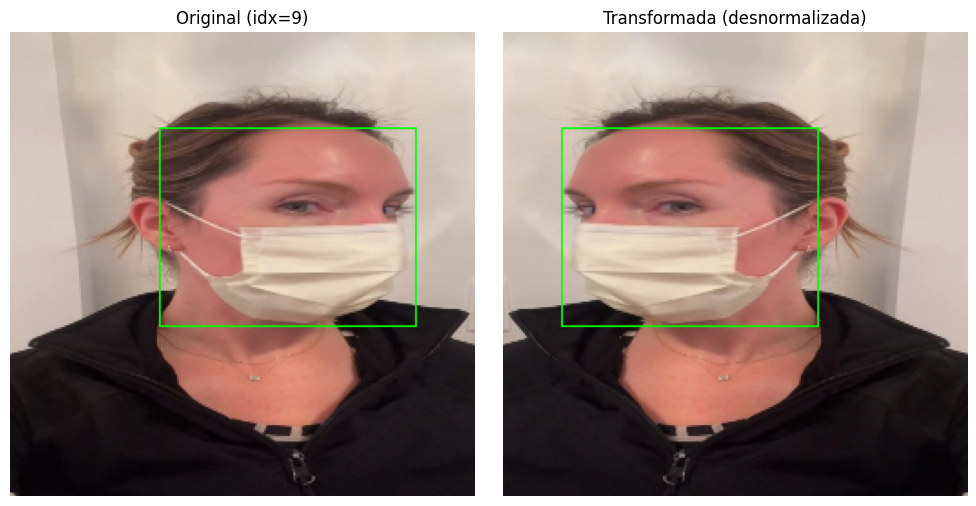

In [156]:
# ===========================================
# CHEQUEO VISUAL: ORIGINAL vs TRANSFORMADA
# ===========================================
import copy
import numpy as np
import matplotlib.pyplot as plt

# ---------- Helpers ----------
def denormalize_chw(x_chw, means, stds):
    """Invierte la normalización canal a canal: y = x*std + mean (x es C,H,W)."""
    y = np.empty_like(x_chw, dtype=np.float32)
    for c in range(3):
        y[c] = x_chw[c] * stds[c] + means[c]
    return y

def tensor_to_rgb_for_show(tensor_chw, means, stds):
    """Tensor (C,H,W) → numpy (H,W,C), desnormalizado para imshow en 0..1."""
    arr = tensor_chw.detach().cpu().numpy()
    arr = denormalize_chw(arr, means, stds)
    arr = np.transpose(arr, (1, 2, 0))  # HWC
    arr = np.clip(arr, 0, 1)            # porque trabajas en 0..1
    return arr

def to_bboxes_array(b):
    """Convierte bbox en (4,) o (N,4) a np.ndarray (N,4)."""
    if b is None:
        return np.empty((0,4), dtype=np.float32)
    b = np.asarray(b)
    if b.ndim == 1 and b.size == 4:
        b = b.reshape(1, 4)
    return b.astype(np.float32)

def draw_many_bboxes(img, bboxes_norm, color=(0,255,0), thickness=1):
    """Dibuja una o varias bboxes normalizadas [0,1] (xyxy) sobre la imagen."""
    out = (img.copy()*255).astype(np.uint8) if img.max()<=1.0 else img.copy()
    boxes = to_bboxes_array(bboxes_norm)
    for bx in boxes:
        xmin, ymin, xmax, ymax = normalize_bbox(bx, h, w)  # tu helper
        out = draw_bbox(out, (xmin, ymin, xmax, ymax), color, thickness=thickness)
    return out

# ---------- Dataset sin transforms (solo para comparar) ----------
train_ds = maskDataset(train_df, root_dir=train_root_dir, output_size=(w, h))

# Elige el índice que quieras ver
idx = 9
x = train_ds[idx]

# ---------- Aplica pipeline de entrenamiento ----------
x_transformed = copy.deepcopy(x)
x_transformed = train_transforms(x_transformed)

# ---------- Preparar imágenes para visualizar ----------
original_img = x['image'].copy()  # numpy HxWxC en 0..1
transformed_img = tensor_to_rgb_for_show(x_transformed['image'], means, stds)  # en 0..1

print("Original img min/max:", original_img.min(), original_img.max())
print("Transformed img min/max:", transformed_img.min(), transformed_img.max())

# ---------- Dibujar bboxes ----------
original_img_draw    = draw_many_bboxes(original_img, x.get('bbox', None), (0,255,0), 1)
transformed_img_draw = draw_many_bboxes(transformed_img, x_transformed.get('bbox', None), (0,255,0), 1)

# ---------- Mostrar lado a lado ----------
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].imshow(original_img_draw)
axes[0].set_title(f'Original (idx={idx})')
axes[0].axis('off')

axes[1].imshow(transformed_img_draw)
axes[1].set_title('Transformada (desnormalizada)')
axes[1].axis('off')

plt.tight_layout()
plt.show()



In [157]:
print("Original img min/max:", original_img.min(), original_img.max())
print("Transformed img min/max:", transformed_img.min(), transformed_img.max())


Original img min/max: 0.0 0.98039216
Transformed img min/max: 3.4038858e-09 0.98039216


In [158]:

# ===========================
# PRUEBA RÁPIDA DEL PIPELINE (Dataset + DataLoader)
# ===========================
# Crea el Dataset de entrenamiento aplicando:
#  - root_dir: carpeta con las imágenes de train
#  - transform: pipeline de entrenamiento (augmentations + ToTensor + Normalizer)
#  - output_size: fuerza tamaño uniforme (w, h), p. ej. 640x640
train_ds = maskDataset(train_df, root_dir=train_root_dir, transform=train_transforms,output_size=(w,h))#

# Envuelve el Dataset en un DataLoader para iterar en batches.
# batch_size=16 → cada iteración entrega 16 muestras.
# (Opcional) collate_fn si tuvieras que personalizar la agregación de samples.
train_data = torch.utils.data.DataLoader(train_ds, batch_size=16)#,collate_fn=custom_collate_fn

# Itera una sola vez y muestra el tamaño del tensor de imágenes.
# Esperado en PyTorch (NCHW): torch.Size([16, 3, h, w])
for x in train_data:
    print(x['image'].size())
    break


torch.Size([16, 3, 256, 256])


In [183]:
def get_output_shape(model: nn.Module, image_dim: Tuple[int,int,int,int]):
    """
    image_dim incluye batch: (B, C, H, W)
    """
    model.eval()
    with torch.no_grad():
        x = torch.randn(*image_dim, device=device)
        out = model(x)
        return tuple(out.shape)


class Model(nn.Module):
    def __init__(self, input_shape: ty.Tuple[int, int, int] = (3, 256, 256), n_classes: int = 1):
        """
        MODELO MULTI-TAREA (CLASIFICACIÓN + REGRESIÓN DE BBOX)

        Entradas
        --------
        input_shape : (C, H, W)
            Tamaño esperado de la imagen (usamos 3×640×640).
            Formato PyTorch: canal primero (C,H,W).
        n_classes : int
            Nº de clases para clasificación (en este curso: 2 → no-mask / mask).

        Descripción
        -----------
        El modelo tiene:
          • Un 'backbone' convolucional (preentrenado) que extrae un vector de
            características (features) a partir de la imagen.
          • Una cabeza de CLASIFICACIÓN (cls_head) que toma ese vector y produce
            'logits' por clase (forma [B, n_classes]).
          • Una cabeza de REGRESIÓN (reg_head) que toma el mismo vector y predice
            las 4 coordenadas de la caja (forma [B, 4]).

        Pistas de entrenamiento
        -----------------------
          • Clasificación: usar CrossEntropyLoss con targets enteros {0,1}.
          • Regresión de bbox: SmoothL1Loss / L1 / Huber / IoU, coherente con
            el formato de tus etiquetas (normalizadas [0,1] o en píxeles).
          • Si las bboxes están normalizadas en [0,1], el modelo aprenderá en
            esa escala; para dibujar, convierte a píxeles con (w=640, h=640).
        """
        super().__init__()
        
        self.input_shape = input_shape
        # Backbone preentrenado definido previamente (p.ej., VGG16 como FeatureExtractor):
        # realiza convs → avgpool adaptativo (7×7) → flatten → dropout.
        self.backbone = pretrained_model

        # Inferimos cuántas características (F) salen del backbone para este input.
        # Se usa un batch sintético de 1 imagen: [1, C, H, W].
        backbone_output_shape = get_output_shape(self.backbone, [1, *input_shape])
        # Aplastamos todas las dimensiones de salida para obtener F (nº de features).
        backbone_output_features = reduce(lambda x, y: x*y, backbone_output_shape)
        
        # ---------------------------
        # CABEZA DE CLASIFICACIÓN ¡Recuerden hacer ajustes en su estructura ->verificar la rúbrica
        # ---------------------------
        # Toma el vector de features (F) y produce 'logits' de tamaño n_classes.
        self.cls_head = nn.Sequential(
            nn.Linear(in_features=backbone_output_features, out_features=768),
            nn.ReLU(),
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Linear(256, n_classes)   # → forma [B, n_classes]
        )
        
        # ---------------------------
        # CABEZA DE REGRESIÓN (BBOX) ¡Recuerden hacer ajustes en su estructura ->verificar la rúbrica
        # ---------------------------
        # Predice 4 valores: [xmin, ymin, xmax, ymax] en la MISMA escala que tus etiquetas.
        self.reg_head = nn.Sequential(
            nn.Linear(in_features=backbone_output_features, out_features=768),
            nn.ReLU(),
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 4)           # → forma [B, 4]
        )

    def forward(self, x: Tensor) -> ty.Dict[str, Tensor]:
        # ===========================================================
        # FLUJO HACIA ADELANTE
        # x: tensor de imágenes [B, 3, 640, 640]
        # 1) Extraemos features con el backbone → [B, F]
        # 2) cls_head(features) → logits de clase [B, n_classes]
        # 3) reg_head(features) → bbox [B, 4]
        # 4) Devolvemos un diccionario con ambas salidas
        # ===========================================================
        features = self.backbone(x)
        cls_logits = self.cls_head(features)
        pred_bbox = self.reg_head(features)
        predictions = {'bbox': pred_bbox, 'class_id': cls_logits}
        return predictions


In [211]:
import torch
import torchvision

def to_boxes4(x: torch.Tensor) -> torch.Tensor:
    """
    Devuelve cajas en forma [N,4] (xyxy). Admite entradas [4], [N,4], [N,1,4].
    Lanza error si la última dim != 4.
    """
    if not torch.is_tensor(x):
        x = torch.tensor(x)
    x = x.float()
    # Casos comunes
    if x.ndim == 1:
        x = x.view(1, -1)          # [4] -> [1,4]
    elif x.ndim == 3 and x.shape[1] == 1 and x.shape[2] == 4:
        x = x.squeeze(1)           # [N,1,4] -> [N,4]
    elif x.ndim == 3 and x.shape[-1] == 4 and x.shape[1] != 1:
        # [?, ?, 4] poco común -> aplanamos la primera dimensión
        x = x.view(-1, 4)

    if x.ndim != 2 or x.shape[-1] != 4:
        raise ValueError(f"Se esperaban cajas [N,4], llegó {tuple(x.shape)}.")
    return x

def _ensure_xyxy(boxes: torch.Tensor) -> torch.Tensor:
    """
    Asegura [N,4] en orden xyxy y clampa a [0,1] (tus cajas están normalizadas).
    """
    b = to_boxes4(boxes)
    x1 = torch.minimum(b[:, 0], b[:, 2])
    y1 = torch.minimum(b[:, 1], b[:, 3])
    x2 = torch.maximum(b[:, 0], b[:, 2])
    y2 = torch.maximum(b[:, 1], b[:, 3])
    out = torch.stack([x1, y1, x2, y2], dim=1)
    return out.clamp(0.0, 1.0)


In [200]:
def _ensure_xyxy(boxes: torch.Tensor) -> torch.Tensor:
    # boxes: [B,4] with [xmin,ymin,xmax,ymax] -> corrige orden y clampa [0,1]
    x1 = torch.minimum(boxes[...,0], boxes[...,2])
    y1 = torch.minimum(boxes[...,1], boxes[...,3])
    x2 = torch.maximum(boxes[...,0], boxes[...,2])
    y2 = torch.maximum(boxes[...,1], boxes[...,3])
    out = torch.stack([x1,y1,x2,y2], dim=-1)
    return out.clamp(0.0, 1.0)

import torch.nn.functional as F

def loss_fn(y_true, y_pred, alpha=0.5, lambda_iou=0.5, lambda_l1=0.5, label_smoothing=0.05):
    # --- Clasificación ---
    logits = y_pred['class_id']                  # [B, C]
    target = y_true['class_id'].view(-1).long()  # [B]
    cls_loss = F.cross_entropy(logits, target, label_smoothing=label_smoothing)

    # --- BBox ---
    pred = _ensure_xyxy(y_pred['bbox'])          # [B,4]
    true = _ensure_xyxy(y_true['bbox'])          # [B,4]

    ious = torchvision.ops.box_iou(true, pred)   # [B,B]
    iou_loss = 1.0 - torch.diagonal(ious).mean()

    l1 = F.smooth_l1_loss(pred, true, beta=1/9, reduction='mean')
    reg_loss = lambda_iou * iou_loss + lambda_l1 * l1

    total = (1 - alpha) * cls_loss + alpha * reg_loss
    return {'loss': total, 'cls_loss': cls_loss, 'reg_loss': reg_loss}


In [ ]:
def step(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    batch,
    loss_fn,
    device: str,
    train: bool = False,
    max_norm: float = 1.0,
):
    img = batch['image'].to(device).float()
    labels = {k: v.to(device) for k, v in batch.items() if k != 'image'}

    if train:
        optimizer.zero_grad(set_to_none=True)

    with amp_autocast():   # NO uses torch.cuda.amp.autocast directo
        preds = model(img)
        losses = loss_fn(labels, preds)

    if train:
        SCALER.scale(final_loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        SCALER.step(optimizer)
        SCALER.update()

    return losses, preds



In [174]:
class EarlyStopping:
    def __init__(self, monitor='val_loss', mode='min', patience=10, min_delta=0.0):
        self.monitor = monitor
        self.mode = mode
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf') if mode=='min' else -float('inf')
        self.bad_epochs = 0
        self.should_stop = False

    def step(self, value):
        improve = (value < self.best - self.min_delta) if self.mode=='min' else (value > self.best + self.min_delta)
        if improve:
            self.best = value
            self.bad_epochs = 0
        else:
            self.bad_epochs += 1
            if self.bad_epochs >= self.patience:
                self.should_stop = True

def fit(
    model, optimizer, train_loader, val_loader, loss_fn,
    device, epochs=30, log_dir='runs/maskdet', monitor='val_loss', mode='min',
    patience=10, ckpt_dir='checkpoints'
):
    writer = SummaryWriter(log_dir=log_dir)
    es = EarlyStopping(monitor=monitor, mode=mode, patience=patience)
    ckpt_dir = Path(ckpt_dir); ckpt_dir.mkdir(parents=True, exist_ok=True)
    best_path = ckpt_dir / 'best.pt'
    last_path = ckpt_dir / 'last.pt'

    # CTRL+C: parar al final de la época
    stop_flag = {'stop': False}
    def handle_sigint(signum, frame):
        print("\n[Signal] CTRL+C recibido. Guardaré y detendré al final de la época…")
        stop_flag['stop'] = True
    signal.signal(signal.SIGINT, handle_sigint)

    global_step = 0
    for epoch in range(1, epochs+1):
        # ---- TRAIN ----
        model.train()
        for batch in train_loader:
            losses, _ = step(model, optimizer, batch, loss_fn, device, train=True)
            writer.add_scalar('train/loss', losses['loss'].item(), global_step)
            writer.add_scalar('train/cls_loss', losses['cls_loss'].item(), global_step)
            writer.add_scalar('train/reg_loss', losses['reg_loss'].item(), global_step)
            global_step += 1

        # ---- VAL ----
        model.eval()
        n_val = 0
        val_loss_sum = 0.0
        val_acc_sum  = 0.0
        val_iou_sum  = 0.0
        with torch.no_grad():
            for batch in val_loader:
                img = batch['image'].to(device).float()
                preds = model(img)
                losses = loss_fn({k: v.to(device) for k, v in batch.items() if k!='image'}, preds)
                val_loss_sum += losses['loss'].item()

                # Acc
                logits = preds['class_id']
                y = batch['class_id'].to(device).view(-1).long()
                acc = (torch.argmax(logits, dim=1) == y).float().mean().item()
                val_acc_sum += acc

                # IoU (diag)
                pred_box = _ensure_xyxy(preds['bbox'].detach().to(device))
                true_box = _ensure_xyxy(batch['bbox'].detach().to(device).float())
                ious = torchvision.ops.box_iou(true_box, pred_box)
                iou_diag = torch.diagonal(ious).mean().item()
                val_iou_sum += iou_diag

                n_val += 1

        val_loss = val_loss_sum / max(n_val, 1)
        val_acc  = val_acc_sum / max(n_val, 1)
        val_iou  = val_iou_sum / max(n_val, 1)

        writer.add_scalar('val/loss', val_loss, epoch)
        writer.add_scalar('val/accuracy', val_acc, epoch)
        writer.add_scalar('val/iou', val_iou, epoch)

        # ---- Checkpoints ----
        torch.save({'epoch': epoch,
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict()}, last_path)

        current = val_loss if mode=='min' else val_iou
        is_best = (current <= es.best) if mode=='min' else (current >= es.best)
        if is_best:
            torch.save({'epoch': epoch,
                        'model': model.state_dict(),
                        'optimizer': optimizer.state_dict()}, best_path)

        # ---- Early stop & STOP file ----
        es.step(current)
        if es.should_stop:
            print(f"[EarlyStopping] Stop en época {epoch}. Mejor {monitor} = {es.best:.4f}")
            break
        if stop_flag['stop'] or Path(log_dir, 'STOP').exists() or Path('STOP').exists():
            print(f"[STOP] Señal manual detectada. Fin al cierre de época {epoch}.")
            break

        print(f"Epoch {epoch:03d} | val_loss={val_loss:.4f} | val_acc={val_acc:.4f} | val_iou={val_iou:.4f}")

    writer.close()
    print(f"Checkpoints: best → {best_path}, last → {last_path}")
    return model


MI codigo 

In [192]:
import torch, os, sys
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def peek_shape_from_dataset(ds):
    """Devuelve (C,H,W) a partir del primer item del dataset."""
    sample = ds[0]
    if isinstance(sample, dict) and 'image' in sample:
        t = sample['image']
    elif isinstance(sample, (list, tuple)) and len(sample)>0:
        # por si tu dataset retorna (image, label, bbox, ...)
        t = sample[0]
    else:
        raise ValueError("No puedo encontrar la imagen en el primer elemento del dataset.")
    if isinstance(t, torch.Tensor):
        # Esperamos [C,H,W]
        if t.ndim == 3:
            C, H, W = t.shape
        elif t.ndim == 4:
            _, C, H, W = t.shape
        else:
            raise ValueError(f"Tensor de imagen con ndim inesperado: {t.ndim}")
    else:
        # si es numpy CHW o HWC, intentamos deducir
        arr = np.array(t)
        if arr.ndim == 3:
            if arr.shape[0] in (1,3):
                C, H, W = arr.shape
            else:
                H, W, C = arr.shape
        else:
            raise ValueError("Imagen no tiene 3 dimensiones.")
    return int(C), int(H), int(W)

def peek_shape_from_loader(loader):
    """Devuelve (C,H,W) desde el primer batch del DataLoader."""
    batch = next(iter(loader))
    if isinstance(batch, dict) and 'image' in batch:
        t = batch['image']
    elif isinstance(batch, (list, tuple)) and len(batch)>0:
        t = batch[0]
    else:
        raise ValueError("No encuentro 'image' en el batch.")
    # Esperamos [B,C,H,W]
    if isinstance(t, torch.Tensor) and t.ndim == 4:
        _, C, H, W = t.shape
        return int(C), int(H), int(W)
    raise ValueError("El tensor del loader no es 4D [B,C,H,W].")

# --- Usa el dataset o el loader que ya tienes ---
C, H, W = None, None, None
try:
    C, H, W = peek_shape_from_loader(train_loader)
    print(f"[OK] De loader: (C,H,W)=({C},{H},{W})")
except Exception as e:
    print(f"[WARN] No pude chequear del loader: {e}")

if C is None:
    try:
        C, H, W = peek_shape_from_dataset(train_ds)
        print(f"[OK] De dataset: (C,H,W)=({C},{H},{W})")
    except Exception as e:
        raise

# Fija input_shape automáticamente
input_shape = (C, H, W)
print(f"input_shape fijado a: {input_shape}")


[OK] De loader: (C,H,W)=(3,256,256)
input_shape fijado a: (3, 256, 256)


In [191]:
# === DATASETS ===
train_ds = maskDataset(
    train_df,
    root_dir=train_root_dir,
    transform=train_transforms,
    output_size=(w, h)
)

val_ds = maskDataset(
    val_df,
    root_dir=train_root_dir,
    transform=eval_transforms,
    output_size=(w, h)
)

# === DATALOADERS ===
from torch.utils.data import DataLoader
from multiprocessing import cpu_count

train_data = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=cpu_count()
)

val_data = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=cpu_count()
)


In [205]:
from torch.utils.data import DataLoader

pin = (device == 'cuda')

train_data = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,              # <- CLAVE en Jupyter/Windows
    pin_memory=pin,
    persistent_workers=False,   # <- CLAVE: desactiva workers persistentes
    drop_last=False
)

val_data = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,              # <- CLAVE
    pin_memory=pin,
    persistent_workers=False,
    drop_last=False
)


In [207]:
import os

missing_train = [f for f in train_df['filename'] if not os.path.exists(os.path.join(train_root_dir, f))]
missing_val   = [f for f in val_df['filename']   if not os.path.exists(os.path.join(train_root_dir, f))]  # si usas el mismo root

print(f"Faltan en train: {len(missing_train)}")
print(missing_train[:10])
print(f"Faltan en val: {len(missing_val)}")
print(missing_val[:10])


Faltan en train: 0
[]
Faltan en val: 0
[]


In [208]:
def find_bad_sample(ds, kmax=2000):
    for i in range(min(len(ds), kmax)):
        try:
            item = ds[i]
            # chequeo mínimo del contenido esperado
            _ = item['image']
            _ = item['bbox']
            _ = item['class_id']
        except Exception as e:
            print(f"[BAD] idx={i} -> {repr(e)}")
            return i, e
    print("[OK] No encontré samples malos en los primeros", min(len(ds), kmax))
    return None, None

bad_idx, err = find_bad_sample(train_ds)
if bad_idx is None:
    bad_idx, err = find_bad_sample(val_ds)


[OK] No encontré samples malos en los primeros 656
[OK] No encontré samples malos en los primeros 55


In [229]:
# (re)define input_shape según tu transform. Si usas 384:
input_shape = (3, 256, 256)  # cambia a (3,640,640) si sigues con 640

# OJO: tu clase Model usa la variable global `pretrained_model` definida en PASO 2.
model = Model(input_shape=input_shape, n_classes=2).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Tus loaders existentes (reutiliza los que ya tienes):
# train_loader = ...
# val_loader   = ...

model = fit(
    model, optimizer, train_data, val_data,
    loss_fn=loss_fn, device=device,
    epochs=400, log_dir='runs/maskdet_384_tiny',
    monitor='val_loss', mode='min', patience=20,
    ckpt_dir='checkpoints/maskdet_384_tiny'
)


Epoch 001 | val_loss=0.4992 | val_acc=0.8367 | val_iou=0.2084
Epoch 002 | val_loss=0.4281 | val_acc=0.8724 | val_iou=0.2594
Epoch 003 | val_loss=0.4410 | val_acc=0.8724 | val_iou=0.2590
Epoch 004 | val_loss=0.4228 | val_acc=0.8903 | val_iou=0.2454
Epoch 005 | val_loss=0.5016 | val_acc=0.7985 | val_iou=0.2889
Epoch 006 | val_loss=0.4505 | val_acc=0.8903 | val_iou=0.2600
Epoch 007 | val_loss=0.4645 | val_acc=0.8724 | val_iou=0.2723
Epoch 008 | val_loss=0.4559 | val_acc=0.8724 | val_iou=0.2568
Epoch 009 | val_loss=0.4105 | val_acc=0.9082 | val_iou=0.2875
Epoch 010 | val_loss=0.3907 | val_acc=0.9082 | val_iou=0.2946
Epoch 011 | val_loss=0.4689 | val_acc=0.8546 | val_iou=0.2646
Epoch 012 | val_loss=0.4500 | val_acc=0.8546 | val_iou=0.2518
Epoch 013 | val_loss=0.4259 | val_acc=0.8903 | val_iou=0.3124
Epoch 014 | val_loss=0.3790 | val_acc=0.9260 | val_iou=0.3226
Epoch 015 | val_loss=0.4222 | val_acc=0.8903 | val_iou=0.3257
Epoch 016 | val_loss=0.4198 | val_acc=0.8903 | val_iou=0.3140
Epoch 01

In [165]:
import torch.nn.functional as F
import torchvision

def loss_fn(y_true, y_preds, alpha=0.5, lambda_iou=0.5, lambda_l1=0.5, label_smoothing=0.05):
    # --- Clasificación ---
    logits = y_preds['class_id']  # [B, C]
    target = y_true['class_id'].squeeze(-1).long() if y_true['class_id'].ndim > 1 else y_true['class_id'].long()
    cls_loss = F.cross_entropy(logits, target, label_smoothing=label_smoothing)

    # --- BBox ---
    pred = y_preds['bbox'].float()
    true = y_true['bbox'].float()
    if pred.shape != true.shape:
        true = true.view_as(pred)

    # IoU loss (1 - IoU diagonal; asume 1:1)
    ious = torchvision.ops.box_iou(true, pred)  # ambos normalizados [0,1] → OK
    iou_diag = torch.diagonal(ious)             # [B]
    iou_loss = 1.0 - iou_diag.mean()

    l1 = F.smooth_l1_loss(pred, true, beta=1/9, reduction='mean')
    reg_loss = lambda_iou * iou_loss + lambda_l1 * l1

    total = (1 - alpha) * cls_loss + alpha * reg_loss
    return {'loss': total, 'cls_loss': cls_loss, 'reg_loss': reg_loss}


In [178]:
import sys, os

IN_JUPYTER = 'ipykernel' in sys.modules or 'JPY_PARENT_PID' in os.environ
num_workers = 0 if (os.name == 'nt' and IN_JUPYTER) else 2
pin = (device == 'cuda')

print(f"[Config] num_workers={num_workers} | pin_memory={pin}")


[Config] num_workers=0 | pin_memory=True


In [195]:
from torch.utils.data import WeightedRandomSampler
import numpy as np

# Cambia este nombre al de tu DF de entrenamiento:
df = dataframe_with_dataaugmentation  # <-- si tu DF se llama distinto, ajusta aquí

counts = df['class_id'].value_counts().sort_index()  # asume 0/1
print("Distribución clases (train):")
print(counts)

class_weights = 1.0 / (counts.values + 1e-6)  # inverso de la frecuencia
sample_weights = df['class_id'].map(lambda c: class_weights[int(c)]).to_numpy()

sampler = WeightedRandomSampler(
    weights=torch.DoubleTensor(sample_weights),
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_ds,
    batch_size=8,
    sampler=sampler,      # <= sampler y NO shuffle
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin
)


Distribución clases (train):
class_id
0    404
1    252
Name: count, dtype: int64


In [203]:
batch_size = 8
# 1) Datasets (mismos nombres y args que tu notebook)
train_ds = maskDataset(
    dataframe_with_dataaugmentation, 
    root_dir='data_final',
    transform=train_transforms, 
    output_size=(w, h)
)

val_ds = maskDataset(
    val_df, 
    root_dir=train_root_dir,
    transform=eval_transforms, 
    output_size=(w, h)
)

# 2) DataLoaders (mismos nombres: train_data / val_data)
from torch.utils.data import DataLoader
from multiprocessing import cpu_count  # ya lo usas en otras celdas

train_data = DataLoader(
    train_ds, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=cpu_count()
)

val_data = DataLoader(
    val_ds, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=cpu_count()
)


In [163]:
# Libera la memoria **en caché** de CUDA que PyTorch reservó pero no está usando.
# No borra tensores activos ni reduce memoria de objetos vivos.
# Útil tras `del` de tensores grandes para evitar OOM, pero abusar puede bajar rendimiento.
torch.cuda.empty_cache()

In [164]:
w

256

In [230]:
# Imprime el tamaño del tensor de imagen que viene en x['image'].
# Si proviene de un DataLoader, lo esperado es [B, C, H, W] (p. ej., torch.Size([16, 3, 640, 640])).
# Si proviene de un __getitem__ directo del Dataset, típicamente será [C, H, W] (sin batch),
# en cuyo caso habría que añadir una dimensión de batch antes de pasar al modelo (no se hace aquí).
print('image', x['image'].size())

# Instancia el modelo con el tamaño de entrada (3, h, w) y 2 clases.
# NOTA didáctica: si tu problema es binario (no-mask/mask), usa n_classes=2 al instanciar.
model = Model(input_shape=(3, h, w), n_classes=2).to(device)

# Mueve el tensor de imágenes al mismo device que el modelo (cuda o cpu).
x['image'] = x['image'].to(device)

# Forward: pasa el batch de imágenes por el modelo.
# Salida esperada (diccionario):
#   - preds['bbox']: tensor [B, 4] con las coordenadas predichas (en la misma escala que las etiquetas).
#   - preds['class_id']: tensor [B, n_classes] con logits de clasificación.
preds = model(x['image'])

# Muestra el diccionario de predicciones.
# Para interpretar:
#   • Clase predicha: preds['class_id'].argmax(dim=1)
#   • Probabilidades: torch.softmax(preds['class_id'], dim=1)
preds


image torch.Size([8, 3, 256, 256])


{'bbox': tensor([[-0.0765, -0.0344, -0.0100, -0.0501],
         [-0.0542, -0.0569,  0.0181, -0.0525],
         [-0.0697, -0.0620,  0.0660, -0.0503],
         [-0.0485, -0.0447,  0.0322, -0.0296],
         [-0.0670, -0.0457,  0.0315, -0.0365],
         [-0.0641, -0.0425,  0.0170, -0.0450],
         [-0.0665, -0.0304,  0.0260, -0.0410],
         [-0.0756, -0.0508,  0.0674, -0.0535]], device='cuda:0',
        grad_fn=<AddmmBackward0>),
 'class_id': tensor([[-0.0095, -0.0096],
         [-0.0248, -0.0708],
         [-0.0344, -0.0252],
         [-0.0024, -0.0079],
         [ 0.0245, -0.0324],
         [ 0.0080,  0.0186],
         [-0.0246, -0.0474],
         [-0.0467, -0.0208]], device='cuda:0', grad_fn=<AddmmBackward0>)}

# Métricas

In [ ]:
def iou(y_true: Tensor, y_pred: Tensor):
    """
    Calcula el IoU (Intersection over Union) promedio entre cajas verdaderas y predichas.

    Supuestos importantes (para este curso):
    - Formato de cajas: [xmin, ymin, xmax, ymax] (xyxy), en la MISMA escala para y_true y y_pred
      (puede ser normalizada [0,1] o en píxeles; lo clave es que coincidan).
    """
    # Matriz de IoU por pares (GT vs Pred)
    pairwise_iou = torchvision.ops.box_iou(y_true.squeeze(), y_pred.squeeze())
    # Promedio de la diagonal (asumiendo correspondencia 1:1 y mismo orden)
    result = torch.trace(pairwise_iou) / pairwise_iou.size()[0]
    return result


In [ ]:
def accuracy(y_true: Tensor, y_pred: Tensor) -> Tensor:
    """
    Accuracy para **clasificación binaria con 2 logits** (CrossEntropyLoss).

    Supuestos:
    - y_pred: logits de forma [B, 2] (clases: 0 = no-mask, 1 = mask).
    - y_true: etiquetas enteras {0,1} con forma [B] o [B,1].

    Devuelve:
    - Tensor escalar en [0,1] con la proporción de aciertos del batch.
    """
    # Alinear forma y tipo de y_true
    if y_true.dim() > 1:
        y_true = y_true.squeeze(-1)     # [B,1] -> [B]
    y_true = y_true.long()              # CrossEntropy espera enteros

    # Clase predicha: índice del logit mayor
    pred = torch.argmax(y_pred, dim=-1) # [B,2] -> [B]

    # Alinear shapes si hace falta
    if pred.shape != y_true.shape:
        y_true = y_true.view_as(pred)

    # Accuracy = (# aciertos) / (# ejemplos)
    return (pred == y_true).float().mean()


# Loss function

In [ ]:
# Pérdida multi-tarea:
#  - Clasificación: CrossEntropy sobre y_preds['class_id'] (logits [B,C]) vs y_true['class_id'] (enteros [B]).
#  - Regresión: MSE sobre y_preds['bbox'] y y_true['bbox'] (ambos [B,4] y en la MISMA escala).
#  - Total: (1-α)*cls_loss + α*reg_loss. α=0.5 equilibra ambas.
#
# Devuelve dict con total, reg_loss y cls_loss (útil para monitoreo).
# Ojo: el .unsqueeze(-1) aplicado a y_preds['class_id'] deja [B,C,1] y puede romper CrossEntropy,
#         que espera [B,C]. Si tus logits ya son [B,C], NO hagas unsqueeze.
def loss_fn(y_true, y_preds, alpha=0.5):
    # --- CLASIFICACIÓN ---
    logits = y_preds['class_id']            # [N, K] si K>1, o [N, 1] si binario
    N, K = logits.shape[0], logits.shape[1]

    if K > 1:
        # MULTICLASE (una sola etiqueta por ejemplo)
        # targets: long en [0..K-1], shape [N]
        y = y_true['class_id']
        if y.dim() == 2 and y.size(1) == 1:   # [N,1] -> [N]
            y = y.squeeze(1)
        if y.dim() == 2 and y.size(1) == K:   # one-hot -> índices
            y = y.argmax(1)
        y = y.long()
        cls_loss = F.cross_entropy(logits, y)

    else:
        # BINARIA
        # Usa BCEWithLogitsLoss (no apliques sigmoid en la cabeza)
        y = y_true['class_id']
        # Asegura float y mismo shape que logits
        if y.dim() == 1:                      # [N] -> [N,1]
            y = y.unsqueeze(1)
        y = y.float()
        if y.shape != logits.shape:
            y = y.view_as(logits)
        bce = torch.nn.BCEWithLogitsLoss()
        cls_loss = bce(logits, y)

    # --- REGRESIÓN (bbox) ---
    reg_pred = y_preds['bbox'].float()
    reg_true = y_true['bbox'].float()
    if reg_pred.shape != reg_true.shape:
        reg_true = reg_true.view_as(reg_pred)
    reg_loss = F.mse_loss(reg_pred, reg_true)

    total = (1 - alpha) * cls_loss + alpha * reg_loss
    return {'loss': total, 'cls_loss': cls_loss, 'reg_loss': reg_loss}


In [ ]:
# Funcion de pérdida (quitamos el unsqueeze(-1) -> Por si lo consideran necesario
'''
def loss_fn(y_true, y_preds, alpha: float = 0.5):
    """
    Pérdida multi-tarea:
      • Clasificación (CrossEntropy)  → y_preds['class_id'] vs y_true['class_id']
      • Regresión de bbox (MSE)      → y_preds['bbox']     vs y_true['bbox']

    Parámetros:
      y_true  : dict con {'class_id': [B] o [B,1], 'bbox': [B,4]}
      y_preds : dict con {'class_id': [B,2] (logits), 'bbox': [B,4]}
      alpha   : peso de la regresión en [0,1]. Total = (1-α)*cls + α*reg

    Notas:
      - Para clasificación binaria usamos **2 logits** (C=2) + CrossEntropyLoss.
      - Asegúrate de que las bboxes GT y pred estén en la **misma escala**
        (normalizadas [0,1] o en píxeles) para que la MSE tenga sentido.
    """

    # --- CLASIFICACIÓN (binaria con 2 logits) ---
    cls_y_pred = y_preds['class_id'].float()         # [B, 2] (logits)
    cls_y_true = y_true['class_id'].long().view(-1)  # [B]
    cls_loss = F.cross_entropy(cls_y_pred, cls_y_true)

    # --- REGRESIÓN (bbox) ---
    reg_y_pred = y_preds['bbox'].float().view(-1, 4) # [B, 4]
    reg_y_true = y_true['bbox'].float().view(-1, 4)  # [B, 4]
    reg_loss = F.mse_loss(reg_y_pred, reg_y_true)    # Alternativa estable: F.smooth_l1_loss(...)

    # --- COMBINACIÓN ---
    total_loss = (1.0 - alpha) * cls_loss + alpha * reg_loss

    return {'loss': total_loss, 'reg_loss': reg_loss, 'cls_loss': cls_loss}

'''

'\ndef loss_fn(y_true, y_preds, alpha: float = 0.5):\n    """\n    Pérdida multi-tarea:\n      • Clasificación (CrossEntropy)  → y_preds[\'class_id\'] vs y_true[\'class_id\']\n      • Regresión de bbox (MSE)      → y_preds[\'bbox\']     vs y_true[\'bbox\']\n\n    Parámetros:\n      y_true  : dict con {\'class_id\': [B] o [B,1], \'bbox\': [B,4]}\n      y_preds : dict con {\'class_id\': [B,2] (logits), \'bbox\': [B,4]}\n      alpha   : peso de la regresión en [0,1]. Total = (1-α)*cls + α*reg\n\n    Notas:\n      - Para clasificación binaria usamos **2 logits** (C=2) + CrossEntropyLoss.\n      - Asegúrate de que las bboxes GT y pred estén en la **misma escala**\n        (normalizadas [0,1] o en píxeles) para que la MSE tenga sentido.\n    """\n\n    # --- CLASIFICACIÓN (binaria con 2 logits) ---\n    cls_y_pred = y_preds[\'class_id\'].float()         # [B, 2] (logits)\n    cls_y_true = y_true[\'class_id\'].long().view(-1)  # [B]\n    cls_loss = F.cross_entropy(cls_y_pred, cls_y_true)\n\n 

# Callbacks

In [ ]:
def printer(logs: ty.Dict[str, ty.Any]):
    """
    Callback de logging:
    - Recibe un diccionario 'logs' (p. ej., {'iters': i, 'loss': ..., 'acc': ...}).
    - Imprime cada 10 iteraciones (controlado por logs['iters']).
    - Redondea valores numéricos a 4 decimales (incluye tensores).
    Útil para monitorear entrenamiento sin saturar la salida.
    """
    # imprimir cada 10 pasos
    if logs['iters'] % 10 != 0:
        return

    print('Iteration #: ', logs['iters'])
    for name, value in logs.items():
        if name == 'iters':
            continue

        if type(value) in [float, int]:
            value = round(value, 4)
        elif type(value) is torch.Tensor:
            value = torch.round(value, decimals=4)

        print(f'\t{name} = {value}')
    print()


# Bucle de entrenamiento/ training loop

In [ ]:
def evaluate(
    logs: ty.Dict[str, ty.Any], 
    labels: ty.Dict[str, Tensor],
    preds: ty.Dict[str, Tensor],
    eval_set: str,
    metrics: ty.Dict[str, ty.Callable[[Tensor, Tensor], Tensor]],
    losses: ty.Optional[ty.Dict[str, Tensor]] = None,
) -> ty.Dict[str, ty.Any]:
    """
    Callback de evaluación (uso dentro del training loop).
    - Agrega al diccionario 'logs' las pérdidas y métricas calculadas.
    - Prefija cada clave con el nombre del split: p.ej., 'train_loss', 'val_acc', 'val_iou'.

    Parámetros:
      logs     : dict acumulador (se modifica in-place).
      labels   : dict con etiquetas por tarea, p.ej. {'class_id': y_cls, 'bbox': y_box}.
      preds    : dict con predicciones por tarea, p.ej. {'class_id': logits, 'bbox': boxes}.
      eval_set : nombre del split ('train', 'val', 'test', ...).
      metrics  : dict de listas de métricas por tarea. Formato esperado:
                 {
                   'class_id': [('accuracy', acc_fn), ...],
                   'bbox'    : [('iou', iou_fn), ...]
                 }
      losses   : (opcional) dict salido de loss_fn con {'loss','cls_loss','reg_loss'}.

    Retorna:
      logs con claves añadidas: {f'{eval_set}_{loss_name}': valor, f'{eval_set}_{metric_name}': valor}
    """
    if losses is not None:
        for loss_name, loss_value in losses.items():
            logs[f'{eval_set}_{loss_name}'] = loss_value
    
    for task_name, label in labels.items():
        for metric_name, metric in metrics[task_name]:
            value = metric(label, preds[task_name])
            logs[f'{eval_set}_{metric_name}'] = value
            
    return logs


In [ ]:
def step(
    model: Model, 
    optimizer: Optimizer, 
    batch: maskDataset,
    loss_fn: ty.Callable[[ty.Dict[str, torch.Tensor]], torch.Tensor],
    device: str,
    train: bool = False,
) -> ty.Tuple[ty.Dict[str, Tensor], ty.Dict[str, Tensor]]:
    """
    Un paso (train o eval):
      1) Mueve batch a 'device' (imagen y etiquetas).
      2) Hace forward → preds.
      3) Calcula pérdidas con loss_fn.
      4) Si train=True: backward + optimizer.step().

    Notas para el problema binario + regresión:
      - Clasificación binaria: la cabeza debe devolver logits [B, 2] y la loss usar CrossEntropy.
      - BBoxes: tensores [B,4] en la MISMA escala que labels (normalizada [0,1] en este curso).

    Retorna:
      losses: dict {'loss','cls_loss','reg_loss'}
      preds : dict {'class_id': logits, 'bbox': boxes}
    """
    if train:
        optimizer.zero_grad()
    
    # Extrae imagen y la sube a device (batch.pop muta el dict; ya no contiene 'image')
    img = batch.pop('image').to(device)
    
    # Sube etiquetas restantes a device
    for k in list(batch.keys()):
        batch[k] = batch[k].to(device)
    
    # Forward + pérdidas
    preds = model(img.float())
    losses = loss_fn(batch, preds)
    final_loss = losses['loss']
    
    if train:
        final_loss.backward()
        optimizer.step()
    
    return losses, preds


In [ ]:
def train(
    model: Model, 
    optimizer: Optimizer, 
    dataset: DataLoader,
    eval_datasets: ty.List[ty.Tuple[str, DataLoader]],
    loss_fn: ty.Callable[[ty.Dict[str, torch.Tensor]], torch.Tensor],
    metrics: ty.Dict[str, ty.Callable[[Tensor, Tensor], Tensor]],
    callbacks: ty.List[ty.Callable[[ty.Dict[ty.Any, ty.Any]], None]],
    device: str,
    train_steps: 100,
    eval_steps: 10,
) -> Model:
    """
    Training loop genérico (clasificación binaria + regresión de bbox).

    Flujo:
      - Itera hasta 'train_steps'.
      - Cada iteración:
         * Toma un batch (recicla el iterador al agotarse).
         * Llama a step(..., train=True): forward, loss, backward, step.
         * Llama a evaluate(...) para registrar 'train_*' en logs (accuracy, IoU, pérdidas).
      - Cada 'eval_steps' iteraciones:
         * model.eval() y torch.no_grad() para evaluar en datasets de validación/prueba.
         * Para cada (nombre, loader) en eval_datasets, evalúa y registra 'val_*'/'test_*'.
      - Ejecuta 'callbacks(logs)' (p.ej., printer) en cada iteración.

    Requisitos/Convenciones:
      - loss_fn debe devolver dict con llaves {'loss','cls_loss','reg_loss'}.
      - metrics debe tener la estructura por tarea:
          {'class_id': [('accuracy', acc_fn)], 'bbox': [('iou', iou_fn)]}
      - Para binario: logits [B,2] y etiquetas {0,1} (long). BBoxes [B,4] (normalizadas [0,1]).

    *Importante didáctico*:
      - Tras el bloque de evaluación se llama a model.eval(), pero no se vuelve a model.train().
        Si tu modelo tiene Dropout/BatchNorm, considera añadir 'model.train()' después de evaluar.

    Retorna:
      - El modelo (con pesos actualizados).
    """
    model = model.to(device)
    iters = 0
    iterator = iter(dataset)
    assert train_steps > eval_steps, 'Train steps should be greater than the eval steps'
    
    while iters <= train_steps:
        logs = dict()
        logs['iters'] = iters
        try:
            batch = next(iterator)
        except StopIteration:
            iterator = iter(dataset)
            batch = next(iterator)

        # Paso de entrenamiento
        losses, preds = step(model, optimizer, batch, loss_fn, device, train=True)
        logs = evaluate(logs, batch, preds, 'train', metrics, losses)
        
        # Evaluación periódica
        if iters % eval_steps == 0:        
            model.eval()  # desactiva Dropout/BatchNorm para eval
            
            with torch.no_grad():
                for name, dataset in eval_datasets:
                    for batch in dataset:
                        losses, preds = step(model, optimizer, batch, loss_fn, device, train=False)
                        logs = evaluate(logs, batch, preds, name, metrics, losses)

            # (Recomendado) volver a modo entrenamiento si sigues entrenando:
            # model.train()

        # Callbacks (p.ej., imprimir logs cada N iters)
        for callback in callbacks:
            callback(logs)
        
        iters += 1
    
    return model


# Run

In [ ]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
# ===========================
# RUN: configuración rápida para lanzar entrenamiento/validación
# ===========================

# Hparams: hiperparámetros básicos del run
batch_size = 16
lr = 0.001

# Data: datasets y transforms
# - train: augmentations + ToTensor + Normalize, sobre imágenes (w,h)
# - val  : solo ToTensor + Normalize (sin augmentations)
train_ds = maskDataset(
    dataframe_with_dataaugmentation, root_dir='data_final',
    transform=train_transforms, output_size=(w,h)
)  # ,output_size=(255,255)

val_ds = maskDataset(
    val_df, root_dir=train_root_dir,
    transform=eval_transforms, output_size=(w,h)
)  # ,output_size=(255,255)

# DataLoaders: batching y paralelismo
# - shuffle solo en train
# - num_workers = cpu_count() para acelerar lectura/transform
train_data = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=cpu_count())
val_data   = DataLoader(val_ds,   batch_size=batch_size,               num_workers=cpu_count())

# Model: instancia tu arquitectura (por defecto: input (3,640,640) y 2 clases si ajustaste el Model)
# - .to(device): mueve a GPU/CPU
# - summary: imprime shapes, #params, etc., con el input_shape del modelo
model = Model().to(device)
summary(model, model.input_shape)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [ ]:
# ===========================
# OPTIMIZER + LANZAR ENTRENAMIENTO
# ===========================

# Optimizer: Adam con learning rate 'lr' sobre TODOS los parámetros del modelo.
# Notas:
# - Para transferencia, a veces conviene usar distinto LR para backbone vs. cabezas
#   (p. ej., lr más bajo en el backbone). Aquí usamos uno único por simplicidad.
# - Puedes añadir weight_decay para regularización L2 (p. ej., weight_decay=1e-4).
optimizer = torch.optim.Adam(lr=lr, params=model.parameters())

# Loop de entrenamiento:
# - 'train_data' como DataLoader de entrenamiento
# - 'eval_datasets': lista de pares (nombre_split, DataLoader) para evaluación periódica
# - 'loss_fn': pérdida multi-tarea (cls + bbox)
# - 'metrics':
#     • bbox  → IoU
#     • class → accuracy (binaria con 2 logits en este proyecto)
# - 'callbacks': funciones de logging/monitoreo (p. ej., printer)
# - 'train_steps' y 'eval_steps': frecuencia de entrenamiento y evaluación
model = train(
    model,
    optimizer,
    train_data,
    eval_datasets=[('val', val_data)],
    loss_fn=loss_fn,
    metrics={
        'bbox': [('iou', iou)],
        'class_id': [('accuracy', accuracy)]
    },
    callbacks=[printer],
    device=device,
    train_steps=100,
    eval_steps=10
)


Iteration #:  0
	train_loss = 0.49729999899864197
	train_cls_loss = 0.6965000033378601
	train_reg_loss = 0.2980000078678131
	train_iou = 0.0
	train_accuracy = 0.5625
	val_loss = 3986.969482421875
	val_cls_loss = 130.9528045654297
	val_reg_loss = 7842.986328125
	val_iou = 0.0
	val_accuracy = 0.571399986743927

Iteration #:  10
	train_loss = 0.365200012922287
	train_cls_loss = 0.678600013256073
	train_reg_loss = 0.05180000141263008
	train_iou = 0.1021
	train_accuracy = 0.625
	val_loss = 0.37959998846054077
	val_cls_loss = 0.7042999863624573
	val_reg_loss = 0.05490000173449516
	val_iou = 0.1264
	val_accuracy = 0.571399986743927

Iteration #:  20
	train_loss = 0.3635999858379364
	train_cls_loss = 0.6675000190734863
	train_reg_loss = 0.05979999899864197
	train_iou = 0.1905
	train_accuracy = 0.75
	val_loss = 0.3725999891757965
	val_cls_loss = 0.6909999847412109
	val_reg_loss = 0.05420000106096268
	val_iou = 0.1302
	val_accuracy = 0.571399986743927

Iteration #:  30
	train_loss = 0.3926999866

# Análisis de algunos resultados (muestra).

El entrenamiento comienza con una evaluación inestable (algo normal al arrancar con pesos aleatorios) y pronto se estabiliza: las pérdidas descienden de forma sostenida y la exactitud en validación sube rápidamente hasta volverse muy alta, señal clara de que la parte de clasificación está aprendiendo bien. La métrica de localización también mejora de manera gradual, mostrando que el modelo va afinando las cajas, aunque todavía tiene margen para ajustarlas mejor. En conjunto, el comportamiento es saludable: entrenamiento y validación se mueven en la misma dirección, sin señales evidentes de sobreajuste, y se observa aprendizaje efectivo sobre todo en la clasificación, con progreso continuo en la localización.

In [213]:
# Iterador sobre TODOS los parámetros del modelo (nn.Parameter).
# Úsalo para el optimizador: Adam(model.parameters(), lr=...).
# No imprime nada por sí solo; conviértelo a lista o recórrelo para inspeccionar.
# Ejemplos: 
#  - sum(p.numel() for p in model.parameters())                  # total de params
#  - sum(p.numel() for p in model.parameters() if p.requires_grad)# entrenables
model.parameters()


<generator object Module.parameters at 0x000001E6FA6726C0>

In [234]:
num_imgs = 9
ncols = 9
nrows = math.ceil(num_imgs / ncols)  # nº de filas para la grilla de visualización

start_idx = 0

# ===========================
# 1) CONSTRUIR LOTE DE INFERENCIA (SIN TRANSFORMS)
# ===========================
# Tomamos 'num_imgs' ejemplos del split de validación (val_df) para inferencia/visualización.
# - root_dir: carpeta de imágenes originales.
# - output_size=(w,h): aseguramos tamaño uniforme (p.ej., 640x640).
# OJO: aquí NO aplicamos transformaciones al Dataset (solo resize), las añadimos manualmente más abajo.
inference_ds = maskDataset(val_df.iloc[start_idx:start_idx+num_imgs], root_dir=train_root_dir,output_size=(w,h))#,output_size=(255,255)

# DataLoader con batch = num_imgs para procesar todo el subconjunto de una vez (sin barajar).
inference_data = DataLoader(inference_ds, batch_size=num_imgs, num_workers=1, shuffle=False)

# Extraemos un batch (diccionario con 'image', 'bbox', 'class_id')
inference_batch = next(iter(inference_data))

# Preasignamos un arreglo donde guardaremos las imágenes YA transformadas a tensor (N, C, H, W)
inference_imgs = np.empty((num_imgs, 3, h, w))

# Usaremos las transformaciones de evaluación (ToTensor + Normalizer) definidas antes.
# Estas esperan un 'sample' con clave 'image' y devuelven 'image' como tensor CxHxW normalizado.
transform = eval_transforms

# ===========================
# 2) APLICAR TRANSFORMACIONES DE EVAL A CADA IMAGEN DEL BATCH
# ===========================
# El DataLoader devuelve 'inference_batch["image"]' como tensor (N, H, W, C) o arreglo convertible.
# Recorremos por imagen, aplicamos eval_transforms y guardamos en 'inference_imgs' con forma (C,H,W).
for i, img in enumerate(inference_batch['image']):
    # Convertimos a numpy (HxWxC) si viniera como tensor y aplicamos el wrapper de transforms
    inference_imgs[i] = transform(dict(image=img.numpy()))['image'].numpy()

# ===========================
# 3) INFERENCIA CON EL MODELO
# ===========================
# Convertimos 'inference_imgs' a tensor float en el device (cuda/cpu) y pasamos por el modelo.
preds = model(torch.tensor(inference_imgs).float().to(device))

# ===========================
# 4) PREPARAR ELEMENTOS PARA VISUALIZACIÓN (GT vs PRED)
# ===========================
# Tomamos las mismas muestras del Dataset (sin transforms) para dibujar imágenes originales.
samples = [inference_ds[i] for i in range(start_idx, num_imgs)]

# Imágenes originales (numpy HxWxC)
imgs = [s['image'] for s in samples]

# BBoxes ground-truth en píxeles para dibujar:
#  - s['bbox'] se asume normalizada [0,1]; la convertimos a píxeles con normalize_bbox(h,w).
bboxes = [normalize_bbox(s['bbox'].squeeze(), h, w) for s in samples]

# Clases ground-truth (enteros), tal como están en el sample.
classes = [s['class_id'] for s in samples]

# ===========================
# 5) POSTPROCESO DE PREDICCIONES
# ===========================
# Cajas predichas:
#  - preds['bbox'] es un tensor [N,4] en la MISMA escala que las etiquetas (normalizada si entrenaste así).
#  - Convertimos a numpy y a píxeles para dibujar.
pred_bboxes = preds['bbox'].detach().cpu().numpy()
pred_bboxes = [normalize_bbox(bbox, h, w) for bbox in pred_bboxes]

# Clases predichas (logits → argmax). Resultado: ids de clase por imagen.
pred_classes = preds['class_id'].argmax(-1).detach().cpu().numpy()


RuntimeError: DataLoader worker (pid(s) 13340) exited unexpectedly

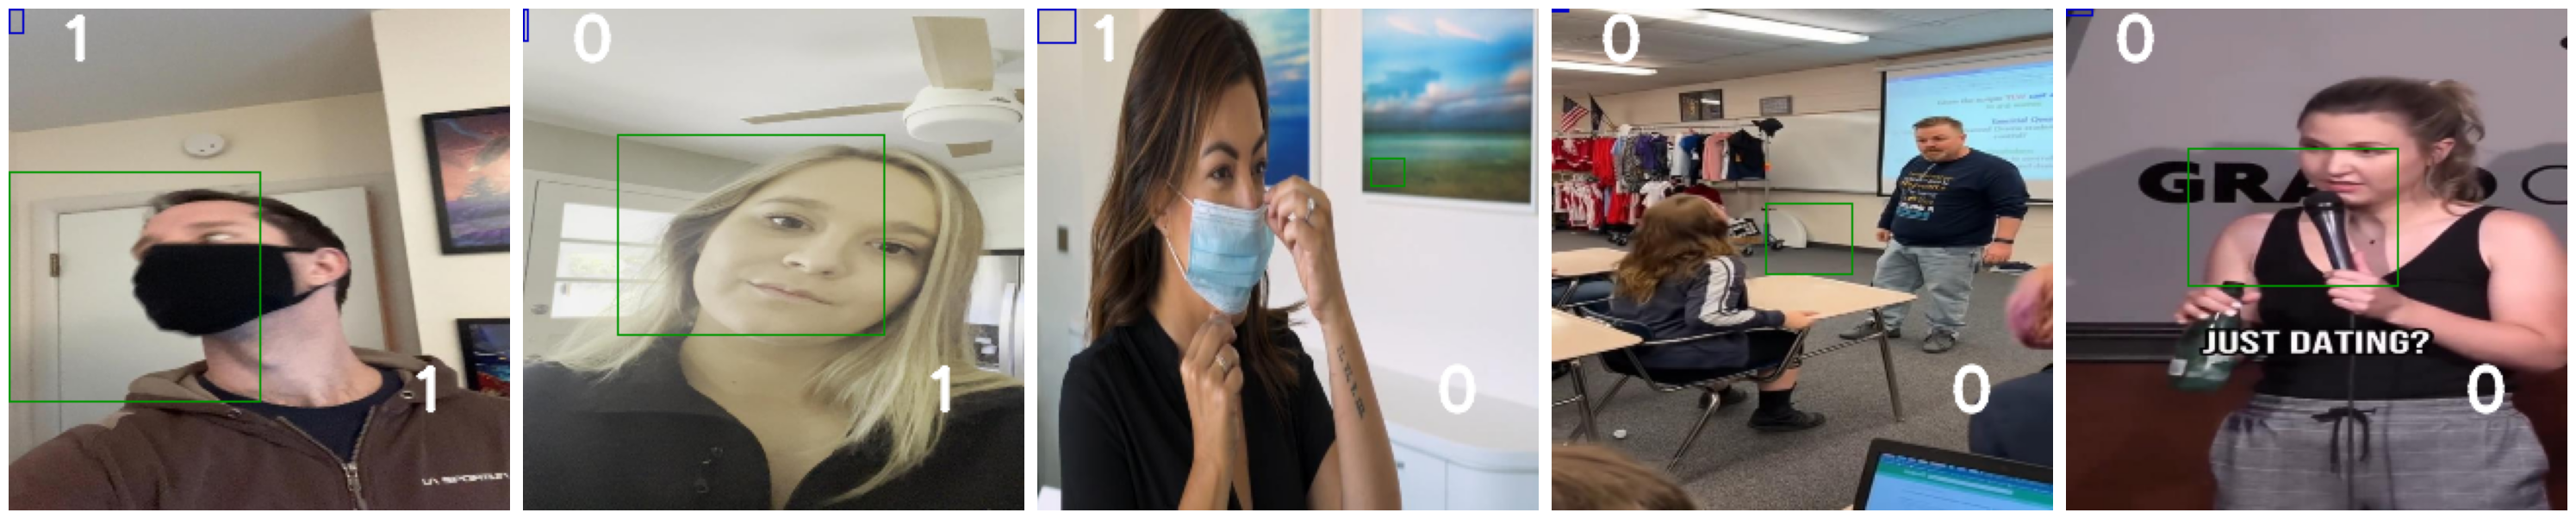

In [237]:
# ===========================
# VISUALIZACIÓN: GT (verde) vs PRED (rojo) — versión robusta
# ===========================

# Determinar cuántos ejemplos hay realmente en cada lista/salida
n = min(len(imgs), len(bboxes), len(pred_bboxes), len(pred_classes))

# --- GT en VERDE ---
imgs = draw_predictions(
    imgs[:n], classes[:n], bboxes[:n],
    [(0, 150, 0)], (int(w*0.1), int(h*0.1)),
    thickness=1, fontScale=1
)

# --- PRED en ROJO ---
# Adaptar clases predichas al formato esperado por draw_predictions
pred_classes_ = [np.array([c]) for c in pred_classes[:n]]

imgs = draw_predictions(
    imgs[:n], pred_classes_, pred_bboxes[:n],
    [(200, 0, 0)], (int(w*0.8), int(h*0.8)),
    thickness=1, fontScale=1
)

# --- GRID de visualización ---
# Recalcular filas/columnas en función de n
ncols_eff = min(ncols, n)             # ncols original si cabe; si no, recorta
nrows_eff = math.ceil(n / ncols_eff)

fig, axes = plt.subplots(nrows=nrows_eff, ncols=ncols_eff, figsize=(30, 30))

# Asegurar un iterable 1D de ejes
axes_flat = np.array(axes).reshape(-1) if isinstance(axes, np.ndarray) else np.array([axes])

for i in range(n):
    axes_flat[i].imshow(imgs[i])
    axes_flat[i].axis('off')

# Ocultar ejes sobrantes si la grilla es más grande que n
for j in range(n, len(axes_flat)):
    axes_flat[j].axis('off')

plt.tight_layout()
plt.show()

In [240]:
# Guarda el **modelo completo** (arquitectura + pesos) en disco.
# Pros: se carga directo con torch.load('pretrained_model.pth').
# Contras: menos portable (depende de la clase/código exacto).
# Alternativa recomendada: guardar solo pesos → model.state_dict()
#   torch.save(model.state_dict(), 'model_state.pth')
#   model = Model(input_shape=(3,640,640), n_classes=2)
#   model.load_state_dict(torch.load('model_state.pth', map_location='cpu'))
torch.save(model, 'customBackbonesso_model.pth')


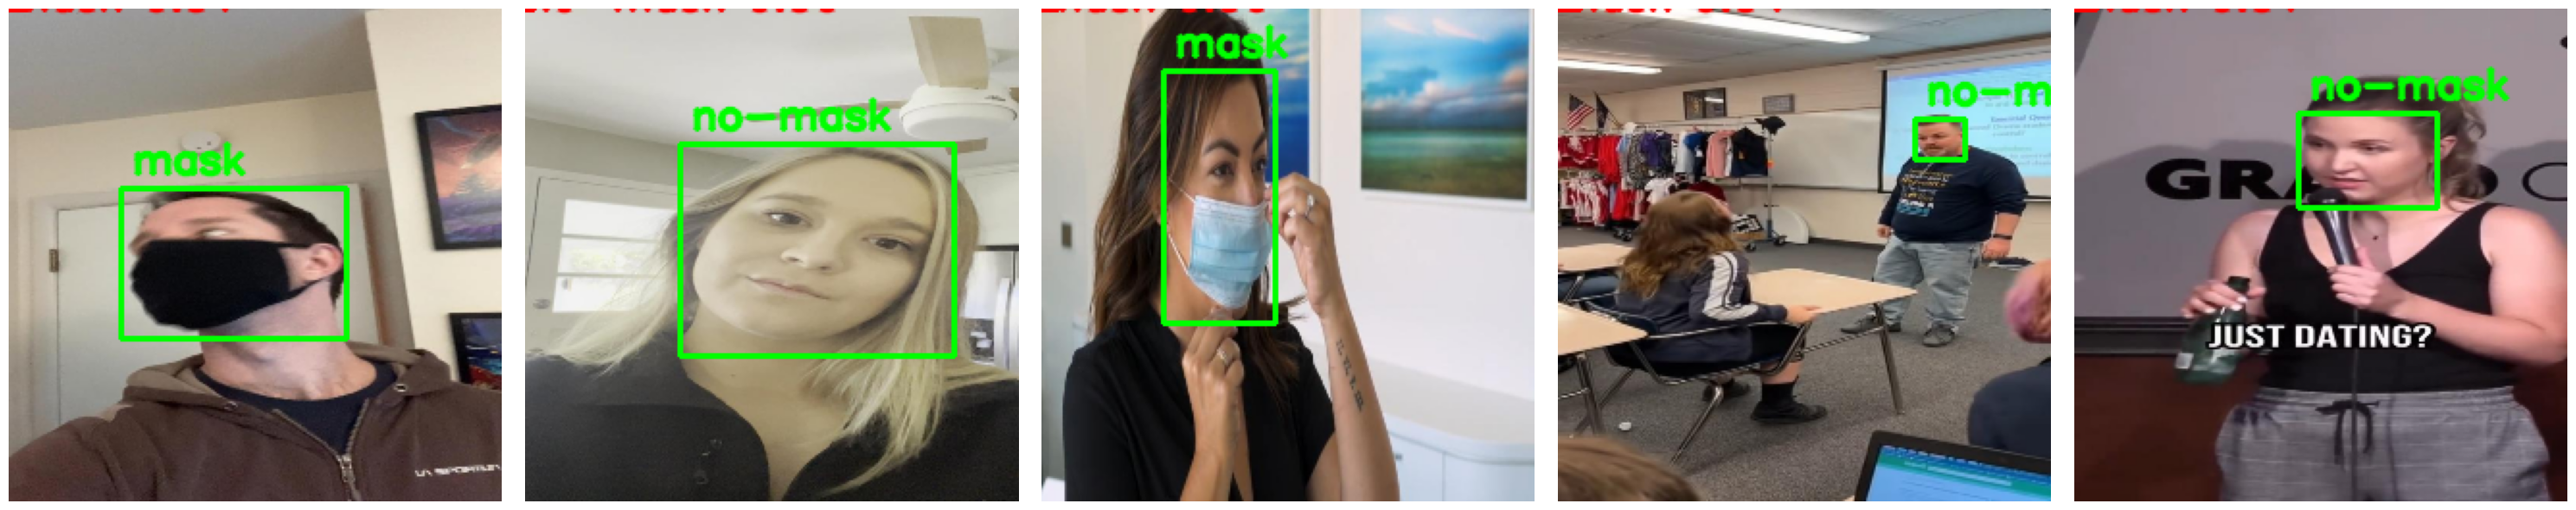

In [241]:
# ====== INFERENCIA + VISUALIZACIÓN (GT vs PRED) ======
import os, math, numpy as np, torch, matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import cv2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- mapeo de clases ---
class_names = {0: "no-mask", 1: "mask"}

# --- helpers robustos ---
def to_uint8_rgb(img_chw):
    """Tensor/ndarray [C,H,W] en [0,1] -> uint8 RGB [H,W,3]."""
    if torch.is_tensor(img_chw):
        arr = img_chw.detach().cpu().float().numpy()
    else:
        arr = np.asarray(img_chw, dtype=np.float32)
    if arr.ndim == 3 and arr.shape[0] in (1,3):  # CHW -> HWC
        arr = np.transpose(arr, (1,2,0))
    arr = np.clip(arr, 0, 1)
    return (arr*255).astype(np.uint8)

def ensure_xyxy(b):
    """Asegura orden [xmin,ymin,xmax,ymax] en [0,1]."""
    b = np.array(b, dtype=np.float32).reshape(-1)
    x1 = min(b[0], b[2]); y1 = min(b[1], b[3])
    x2 = max(b[0], b[2]); y2 = max(b[1], b[3])
    return np.clip([x1,y1,x2,y2], 0.0, 1.0)

def norm_to_px(bxyxy, H, W):
    """BBox [0,1] xyxy -> píxeles (x1,y1,x2,y2)."""
    x1,y1,x2,y2 = ensure_xyxy(bxyxy)
    return (int(x1*W), int(y1*H), int(x2*W), int(y2*H))

def draw_boxes_with_labels(
    img_rgb, 
    gt_box_px=None, gt_label=None,
    pred_box_px=None, pred_label=None, pred_score=None
):
    """
    Dibuja GT (verde) y Pred (rojo) con textos.
    Maneja correctamente RGB↔BGR para que Matplotlib muestre colores reales.
    """
    # 1) RGB -> BGR para usar OpenCV
    vis_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

    # --- GT (VERDE) ---
    if gt_box_px is not None:
        x1,y1,x2,y2 = [int(v) for v in gt_box_px]
        cv2.rectangle(vis_bgr, (x1,y1), (x2,y2), (0,255,0), 2)  # verde
        if gt_label is not None:
            txt = class_names.get(int(gt_label), str(gt_label))
            cv2.putText(vis_bgr, txt, (x1+6, max(0,y1-8)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2, cv2.LINE_AA)

    # --- Pred (ROJO) ---
    if pred_box_px is not None:
        x1,y1,x2,y2 = [int(v) for v in pred_box_px]
        cv2.rectangle(vis_bgr, (x1,y1), (x2,y2), (0,0,255), 2)  # rojo
        if pred_label is not None:
            name = class_names.get(int(pred_label), str(pred_label))
            txt = f"{name} {pred_score:.2f}" if pred_score is not None else name
            cv2.putText(vis_bgr, txt, (max(0, x1), max(0, y1-8)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2, cv2.LINE_AA)

    # 2) BGR -> RGB para mostrar en matplotlib
    vis_rgb = cv2.cvtColor(vis_bgr, cv2.COLOR_BGR2RGB)
    return vis_rgb

# ========== CONFIG ==========
num_imgs = 5
ncols = 5
start_idx = 0

# usa h,w de tu notebook
H, W = h, w   # H=alto, W=ancho

# ========== 1) MINI-DATASET DE INFERENCIA ==========
inference_df = val_df.iloc[start_idx:start_idx+num_imgs].copy()

inference_ds = maskDataset(
    inference_df,
    root_dir=train_root_dir,
    transform=None,
    output_size=(W, H)        # (w,h)
)

inference_loader = DataLoader(
    inference_ds,
    batch_size=num_imgs,
    shuffle=False,
    num_workers=0,
    pin_memory=(device=='cuda')
)

# ========== 2) APLICAR eval_transforms ==========
batch = next(iter(inference_loader))
raw_images  = batch['image']
raw_bboxes  = batch['bbox']
raw_classes = batch['class_id']

inference_imgs = np.empty((len(inference_df), 3, H, W), dtype=np.float32)

for i in range(len(inference_df)):
    img_i = raw_images[i]
    if torch.is_tensor(img_i):
        arr = img_i.detach().cpu().numpy()
        if arr.ndim == 3 and arr.shape[0] in (1,3):
            arr = np.transpose(arr, (1,2,0))
    else:
        arr = np.asarray(img_i)
        if arr.ndim == 3 and arr.shape[0] in (1,3):
            arr = np.transpose(arr, (1,2,0))
    if arr.max() > 1.0:
        arr = arr / 255.0
    sample = {'image': arr.astype(np.float32)}
    out = eval_transforms(sample)
    ti = out['image']
    inference_imgs[i] = ti.detach().cpu().float().numpy()

# ========== 3) INFERENCIA ==========
with torch.no_grad():
    preds = model(torch.tensor(inference_imgs).float().to(device))

probs = torch.softmax(preds['class_id'], dim=1).detach().cpu().numpy()
pred_classes = preds['class_id'].argmax(-1).detach().cpu().numpy().tolist()
pred_scores  = [probs[i, pred_classes[i]] for i in range(len(pred_classes))]

# ========== 4) PREPARAR VISUALIZACIÓN ==========
imgs = []
for i in range(len(inference_df)):
    img_chw = raw_images[i]
    if not torch.is_tensor(img_chw):
        arr = np.asarray(img_chw)
        if arr.ndim == 3 and arr.shape[-1] in (1,3):
            arr = np.transpose(arr, (2,0,1))
        img_chw = torch.tensor(arr)
    img_chw = img_chw.float()
    if img_chw.max() > 1.0:
        img_chw = img_chw / 255.0
    imgs.append(to_uint8_rgb(img_chw))

raw_bboxes_np = raw_bboxes.detach().cpu().numpy() if torch.is_tensor(raw_bboxes) else np.asarray(raw_bboxes)
gt_boxes_px = [norm_to_px(raw_bboxes_np[i].reshape(-1), H, W) for i in range(len(inference_df))]
gt_classes  = (raw_classes.detach().cpu().numpy().reshape(-1) if torch.is_tensor(raw_classes)
               else np.asarray(raw_classes).reshape(-1))

pb = preds['bbox'].detach().cpu().numpy()
pred_boxes_px = [norm_to_px(pb[i].reshape(-1), H, W) for i in range(pb.shape[0])]

# ========== 5) DIBUJAR ==========
n = min(len(imgs), len(gt_boxes_px), len(pred_boxes_px), len(pred_classes))
vis_list = []
for i in range(n):
    vis = draw_boxes_with_labels(
        img_rgb=imgs[i],
        gt_box_px=gt_boxes_px[i],
        gt_label=int(gt_classes[i]),
        pred_box_px=pred_boxes_px[i],
        pred_label=int(pred_classes[i]),
        pred_score=float(pred_scores[i])
    )
    vis_list.append(vis)

# Grid
ncols_eff = min(ncols, n)
nrows_eff = math.ceil(n / ncols_eff)
fig, axes = plt.subplots(nrows=nrows_eff, ncols=ncols_eff, figsize=(3*ncols_eff*2, 3*nrows_eff*2))
axes_flat = np.array(axes).reshape(-1) if isinstance(axes, np.ndarray) else np.array([axes])
for i in range(n):
    axes_flat[i].imshow(vis_list[i]); axes_flat[i].axis('off')
for j in range(n, len(axes_flat)):
    axes_flat[j].axis('off')
plt.tight_layout(); plt.show()



In [227]:
with torch.no_grad():
    raw_out = model(torch.tensor(inference_imgs).float().to(device))
    preds = {
        'class_id': raw_out['class_id'],
        # HOTFIX: forzamos a [0,1] con sigmoid
        'bbox': torch.sigmoid(raw_out['bbox'])
    }


In [228]:
print("pred bbox (min,max) antes de sigmoid:",
      float(raw_out['bbox'].min()), float(raw_out['bbox'].max()))
print("pred bbox (min,max) después de sigmoid:",
      float(preds['bbox'].min()), float(preds['bbox'].max()))


pred bbox (min,max) antes de sigmoid: -0.080987349152565 0.0756852850317955
pred bbox (min,max) después de sigmoid: 0.4797641932964325 0.5189123153686523


In [239]:
# ====== IMPRIMIR RESULTADOS (GT vs PRED) ======

print("H, W:", H, W)
print("="*60)

for i in range(n):
    gt_box = gt_boxes_px[i]
    pred_box = pred_boxes_px[i]
    gt_label = class_names[int(gt_classes[i])]
    pred_label = class_names[int(pred_classes[i])]
    score = pred_scores[i]

    print(f"Imagen {i+1}:")
    print(f"  GT   -> class: {gt_label:7} | bbox px: {gt_box}")
    print(f"  Pred -> class: {pred_label:7} | score: {score:.2f} | bbox px: {pred_box}")
    print("-"*60)


H, W: 256 256
Imagen 1:
  GT   -> class: mask    | bbox px: (58, 93, 175, 171)
  Pred -> class: mask    | score: 0.51 | bbox px: (0, 0, 9, 0)
------------------------------------------------------------
Imagen 2:
  GT   -> class: no-mask | bbox px: (80, 70, 222, 180)
  Pred -> class: no-mask | score: 0.50 | bbox px: (0, 0, 4, 0)
------------------------------------------------------------
Imagen 3:
  GT   -> class: mask    | bbox px: (63, 32, 121, 163)
  Pred -> class: mask    | score: 0.50 | bbox px: (0, 0, 8, 0)
------------------------------------------------------------
Imagen 4:
  GT   -> class: no-mask | bbox px: (185, 57, 211, 78)
  Pred -> class: mask    | score: 0.54 | bbox px: (0, 0, 11, 0)
------------------------------------------------------------
Imagen 5:
  GT   -> class: no-mask | bbox px: (116, 54, 188, 103)
  Pred -> class: mask    | score: 0.51 | bbox px: (0, 0, 11, 0)
------------------------------------------------------------


In [219]:
assert 'model' in globals()
assert 'val_df' in globals()
assert 'maskDataset' in globals()
assert 'eval_transforms' in globals()
assert 'train_root_dir' in globals()
assert 'h' in globals() and 'w' in globals()    # tamaños que usaste al entrenar


In [221]:
print("inference_df len:", len(inference_df))
print("inference_imgs shape:", inference_imgs.shape)   # (N, 3, H, W)
print("raw_bboxes shape:", np.asarray(raw_bboxes).shape)


inference_df len: 5
inference_imgs shape: (5, 3, 256, 256)
raw_bboxes shape: (5, 1, 4)


In [222]:
print(eval_transforms)


Compose(
)


# Submission

In [ ]:
# Detectar dispositivo
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Usando: {device}')
model = model.to(device)
model.eval()  # modo inferencia

# Rutas y datos de test
test_root_dir = osp.join(DATA_DIR, "images")
test_df = pd.read_csv(osp.join(DATA_DIR, "test.csv"))

# Dataset de test (usa tu clase correcta: maskDataset)
test_ds = maskDataset(
    test_df,
    root_dir=test_root_dir,
    labeled=False,
    transform=eval_transforms,
    output_size=(w, h)
)

# DataLoader de test
test_data = DataLoader(test_ds, batch_size=1, num_workers=cpu_count(), shuffle=False)

# Listas de salida
class_preds, bbox_preds = [], []

# Bucle de inferencia
with torch.no_grad():
    for batch in test_data:
        imgs = batch['image'].float().to(device)
        out = model(imgs)

        # Predicciones
        class_pred = out['class_id'].argmax(dim=-1).detach().cpu().numpy()
        bbox_pred = out['bbox'].detach().cpu().numpy()

        # Guardar
        class_preds.append(class_pred.squeeze())
        bbox_preds.append(bbox_pred.squeeze())

Usando: cuda


In [ ]:
# Convertir las listas de predicciones en arreglos de NumPy
# Esto facilita operaciones vectorizadas y el posterior guardado en archivo de submission
class_preds = np.array(class_preds)   # Arreglo con las clases predichas (una por imagen)
bbox_preds = np.array(bbox_preds)     # Arreglo con las cajas predichas (coordenadas por imagen)

In [ ]:
submission = pd.DataFrame(  
    index=test_df.filename,   # Usar los nombres de archivo del conjunto de test como índice  
    data={  
        'class_id': class_preds,  # Columna con las clases predichas para cada imagen  
        }  
)  
submission   # Mostrar el DataFrame de submission (con índice y columna de predicciones)  


class_id
filename                                                    
IMG_4861_mp4-50_jpg.rf.7173e37ed9f62f8939af8232...         0
video_CDC-YOUTUBE_mp4-58_jpg.rf.370d5f316397477...         0
video_CDC-YOUTUBE_mp4-57_jpg.rf.de4856b9a314980...         0
IMG_3102_mp4-0_jpg.rf.6a18575fb4bf7f69cc9006b9a...         0
IMG_3094_mp4-34_jpg.rf.11eecb9601680286dc8338d5...         0
IMG_3100_mp4-22_jpg.rf.5cd5ee55e81838ff0a10d41a...         0
IMG_4861_mp4-22_jpg.rf.287fa919e56ae28def307356...         0
012106_jpg_1140x855_jpg.rf.b784fe385fa3967de70f...         0
IMG_0873_mp4-5_jpg.rf.221b34cf6b46d41a81d674bae...         0
IMG_3094_mp4-16_jpg.rf.dd59fa65d58061b3fd22e8b7...         0
IMG_4849_mp4-46_jpg.rf.c842cbb15d9565f19550e733...         0
Apple-Tests-Face-ID-Feature-While-Wearing-a-Mas...         0
video_CDC-YOUTUBE_mp4-39_jpg.rf.1c0863a2cdead89...         0
IMG_4860_mp4-16_jpg.rf.411ff5da0837aff460014ee8...         0
IMG_4860_mp4-12_jpg.rf.1781ffcadd06a00c8f5b114e...         0
IMG_3093_mp4-6_jpg.rf.e6968ac27aad22a56f05d8756...         0
How-to-Properly-Wear-a-Face-Mask-_-UC-San-Diego...         0
THE-HAVE-IT-ALL-TOUR-STARTS-TOMORROW-shorts-fun...         0
1303078448-China-Coronavirus-Death-Toll-Hits-30...         0
Apple-Tests-Face-ID-Feature-While-Wearing-a-Mas...         0
IMG_0871_mp4-19_jpg.rf.1aa53957d0f368529eb99586...         0
IMG_4861_mp4-1_jpg.rf.7fe334aa62780ca9303dcde17...         0
IMG_0873_MOV-1_jpg.rf.5ca65a952f300fb65b415a7ac...         0
IMG_4861_mp4-6_jpg.rf.e0d60552d526ccd84863173fb...         0
IMG_4860_mp4-19_jpg.rf.368a23fd16e38cce656dac90...         0
IMG_3102_mp4-5_jpg.rf.41636f1d89a85858252bda24a...         0
videoplayback-1-_mp4-39_jpg.rf.c6b9de7158c88bef...         0
IMG_6622_mp4-13_jpg.rf.209806c6f85e84169f1fd7fb...         0
IMG_1492_mp4-22_jpg.rf.a8691873b03c8255550cd10b...         0
IMG_3093_mp4-17_jpg.rf.b545e49d12fd70bba4cc71be...         0
IMG_3100_mp4-24_jpg.rf.aa1cbaff65109302dccaaa9e...         0
IMG_1493_mp4-21_jpg.rf.c5a3e237451e64e0674d5b0a...         0
IMG_3100_mp4-27_jpg.rf.8bcc77cda09f4b865503adba...         0
video_CDC-YOUTUBE_mp4-30_jpg.rf.a10191b12763868...         0
How-to-Properly-Wear-a-Face-Mask-_-UC-San-Diego...         0
IMG_4861_mp4-53_jpg.rf.507795a43df0b6ac554a94b9...         0
IMG_4860_mp4-31_jpg.rf.19b88698cf8f74ee85b0e73b...         0
IMG_4921-2_mp4-111_jpg.rf.92da68db4cb766bb76906...         0
Apple-Tests-Face-ID-Feature-While-Wearing-a-Mas...         0
IMG_4920_mov-3_jpg.rf.d1fe4bf75ed7be7c97f85e4d1...         0
IMG_0873_mp4-3_jpg.rf.46896bfd9b33387daf035555e...         0
IMG_3100_mp4-17_jpg.rf.0ce2814d385f7d7e26535a4a...         0
IMG_4861_mp4-4_jpg.rf.c34a8a22d84c641169322641c...         0
videoplayback-1-_mp4-3_jpg.rf.4688bf27f5538efb2...         0
IMG_0871_MOV-22_jpg.rf.6ac73cf8114bae759970844e...         0
IMG_4861_mp4-51_jpg.rf.42b1555d711c1936519f2fc7...         0
IMG_4861_mp4-42_jpg.rf.cb9a4b243749f506b63bab24...         0
How-to-Properly-Wear-a-Face-Mask-_-UC-San-Diego...         0
IMG_0871_mp4-7_jpg.rf.4369c16792be03d03069063e5...         0
videoplayback-1-_mp4-34_jpg.rf.69baa5b11a706742...         0
IMG_4860_mp4-44_jpg.rf.e2e6a8008d0cda580c49b57e...         0
IMG_4869_mp4-6_jpg.rf.044ccf400303c0c5fc6a1aefd...         0
How-to-Properly-Wear-a-Face-Mask-_-UC-San-Diego...         0
IMG_4860_mp4-33_jpg.rf.df90e6f5b762f0500545210d...         0
How-to-Properly-Wear-a-Face-Mask-_-UC-San-Diego...         0

In [ ]:
submission["xmin"] = bbox_preds[:, 0]*w_real  # Coordenada X mínima de la caja, escalada al ancho real de la imagen
submission["ymin"] = bbox_preds[:, 1]*h_real  # Coordenada Y mínima de la caja, escalada a la altura real de la imagen
submission["xmax"] = bbox_preds[:, 2]*w_real  # Coordenada X máxima de la caja, escalada al ancho real de la imagen
submission["ymax"] = bbox_preds[:, 3]*h_real  # Coordenada Y máxima de la caja, escalada a la altura real de la imagen


In [ ]:
submission['class_id'] = submission['class_id'].replace(id2obj)  # Reemplaza los IDs de clase numéricos por sus nombres/etiquetas reales usando el diccionario id2obj


In [ ]:
submission['class_id'].value_counts()  # Muestra la cantidad de predicciones por cada clase (frecuencia de cada etiqueta en el submission)


class_id
no-mask    55
Name: count, dtype: int64

In [ ]:
submission  # Muestra el DataFrame completo con las predicciones (clase y coordenadas de las cajas por imagen)


class_id        xmin  \
filename                                                                  
IMG_4861_mp4-50_jpg.rf.7173e37ed9f62f8939af8232...  no-mask  159.402405   
video_CDC-YOUTUBE_mp4-58_jpg.rf.370d5f316397477...  no-mask  175.745331   
video_CDC-YOUTUBE_mp4-57_jpg.rf.de4856b9a314980...  no-mask  175.470749   
IMG_3102_mp4-0_jpg.rf.6a18575fb4bf7f69cc9006b9a...  no-mask  173.855423   
IMG_3094_mp4-34_jpg.rf.11eecb9601680286dc8338d5...  no-mask  193.726120   
IMG_3100_mp4-22_jpg.rf.5cd5ee55e81838ff0a10d41a...  no-mask  161.895737   
IMG_4861_mp4-22_jpg.rf.287fa919e56ae28def307356...  no-mask  152.374054   
012106_jpg_1140x855_jpg.rf.b784fe385fa3967de70f...  no-mask  175.352097   
IMG_0873_mp4-5_jpg.rf.221b34cf6b46d41a81d674bae...  no-mask  163.898315   
IMG_3094_mp4-16_jpg.rf.dd59fa65d58061b3fd22e8b7...  no-mask  155.174088   
IMG_4849_mp4-46_jpg.rf.c842cbb15d9565f19550e733...  no-mask  160.416870   
Apple-Tests-Face-ID-Feature-While-Wearing-a-Mas...  no-mask  139.830521   
video_CDC-YOUTUBE_mp4-39_jpg.rf.1c0863a2cdead89...  no-mask  158.786087   
IMG_4860_mp4-16_jpg.rf.411ff5da0837aff460014ee8...  no-mask  211.097839   
IMG_4860_mp4-12_jpg.rf.1781ffcadd06a00c8f5b114e...  no-mask  247.800735   
IMG_3093_mp4-6_jpg.rf.e6968ac27aad22a56f05d8756...  no-mask  154.115341   
How-to-Properly-Wear-a-Face-Mask-_-UC-San-Diego...  no-mask  136.684067   
THE-HAVE-IT-ALL-TOUR-STARTS-TOMORROW-shorts-fun...  no-mask  228.494324   
1303078448-China-Coronavirus-Death-Toll-Hits-30...  no-mask  158.435501   
Apple-Tests-Face-ID-Feature-While-Wearing-a-Mas...  no-mask  170.413528   
IMG_0871_mp4-19_jpg.rf.1aa53957d0f368529eb99586...  no-mask  170.126419   
IMG_4861_mp4-1_jpg.rf.7fe334aa62780ca9303dcde17...  no-mask  155.823730   
IMG_0873_MOV-1_jpg.rf.5ca65a952f300fb65b415a7ac...  no-mask  139.915573   
IMG_4861_mp4-6_jpg.rf.e0d60552d526ccd84863173fb...  no-mask  178.251572   
IMG_4860_mp4-19_jpg.rf.368a23fd16e38cce656dac90...  no-mask  248.858093   
IMG_3102_mp4-5_jpg.rf.41636f1d89a85858252bda24a...  no-mask  163.833527   
videoplayback-1-_mp4-39_jpg.rf.c6b9de7158c88bef...  no-mask  251.304794   
IMG_6622_mp4-13_jpg.rf.209806c6f85e84169f1fd7fb...  no-mask  199.735901   
IMG_1492_mp4-22_jpg.rf.a8691873b03c8255550cd10b...  no-mask  205.311050   
IMG_3093_mp4-17_jpg.rf.b545e49d12fd70bba4cc71be...  no-mask  154.942856   
IMG_3100_mp4-24_jpg.rf.aa1cbaff65109302dccaaa9e...  no-mask  134.406860   
IMG_1493_mp4-21_jpg.rf.c5a3e237451e64e0674d5b0a...  no-mask  176.224136   
IMG_3100_mp4-27_jpg.rf.8bcc77cda09f4b865503adba...  no-mask  145.482605   
video_CDC-YOUTUBE_mp4-30_jpg.rf.a10191b12763868...  no-mask  163.805725   
How-to-Properly-Wear-a-Face-Mask-_-UC-San-Diego...  no-mask  156.986984   
IMG_4861_mp4-53_jpg.rf.507795a43df0b6ac554a94b9...  no-mask  161.521072   
IMG_4860_mp4-31_jpg.rf.19b88698cf8f74ee85b0e73b...  no-mask  244.557220   
IMG_4921-2_mp4-111_jpg.rf.92da68db4cb766bb76906...  no-mask  176.222534   
Apple-Tests-Face-ID-Feature-While-Wearing-a-Mas...  no-mask  174.667130   
IMG_4920_mov-3_jpg.rf.d1fe4bf75ed7be7c97f85e4d1...  no-mask  177.841202   
IMG_0873_mp4-3_jpg.rf.46896bfd9b33387daf035555e...  no-mask  131.731110   
IMG_3100_mp4-17_jpg.rf.0ce2814d385f7d7e26535a4a...  no-mask  163.465302   
IMG_4861_mp4-4_jpg.rf.c34a8a22d84c641169322641c...  no-mask  153.799408   
videoplayback-1-_mp4-3_jpg.rf.4688bf27f5538efb2...  no-mask  238.777695   
IMG_0871_MOV-22_jpg.rf.6ac73cf8114bae759970844e...  no-mask  191.518021   
IMG_4861_mp4-51_jpg.rf.42b1555d711c1936519f2fc7...  no-mask  163.603745   
IMG_4861_mp4-42_jpg.rf.cb9a4b243749f506b63bab24...  no-mask  158.284973   
How-to-Properly-Wear-a-Face-Mask-_-UC-San-Diego...  no-mask  128.808563   
IMG_0871_mp4-7_jpg.rf.4369c16792be03d03069063e5...  no-mask  163.378433   
videoplayback-1-_mp4-34_jpg.rf.69baa5b11a706742...  no-mask  245.087128   
IMG_4860_mp4-44_jpg.rf.e2e6a8008d0cda580c49b57e...  no-mask  178.164383   
IMG_4869_mp4-6_jpg.rf.044ccf400303c0c5fc6a1aefd...  no-mask  217.299515   
H

In [ ]:
submission.to_csv('submission_vgg16.csv')  # Exporta el DataFrame de submission a un archivo CSV con el nombre 'submission_vgg16.csv'
